In [1]:
#importing necessary libraries and frameworks
import numpy as np
import pandas as pd   
import os
from pathlib import Path
import glob
import json
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import nltk
import cv2
import matplotlib.pyplot as plt
import random

#Check GPU is available for training or not Or whether the tensorflow version can utilize gpu 
physical_devices = tf.config.list_physical_devices('GPU') 
print("Number of GPUs :", len(physical_devices)) 
print("Tensorflow GPU :",tf.test.is_built_with_cuda())
if len(physical_devices)>0:
    device="/GPU:0"
else:
    device="/CPU:0"

Number of GPUs : 1
Tensorflow GPU : True


DATA COLLECTION

In [2]:
!wget https://dl.fbaipublicfiles.com/clevr/CLEVR_v1.0.zip

--2023-04-30 17:19:17--  https://dl.fbaipublicfiles.com/clevr/CLEVR_v1.0.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.227.219.59, 13.227.219.33, 13.227.219.70, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.227.219.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19021600724 (18G) [application/zip]
Saving to: ‘CLEVR_v1.0.zip’

CLEVR_v1.0.zip      100%[===================>]  17.71G   235MB/s    in 89s     

2023-04-30 17:20:47 (205 MB/s) - ‘CLEVR_v1.0.zip’ saved [19021600724/19021600724]



In [3]:
!unzip CLEVR_v1.0.zip

Streaming output truncated to the last 5000 lines.
  inflating: CLEVR_v1.0/images/train/CLEVR_train_041020.png  
  inflating: CLEVR_v1.0/images/train/CLEVR_train_068755.png  
  inflating: CLEVR_v1.0/images/train/CLEVR_train_008504.png  
  inflating: CLEVR_v1.0/images/train/CLEVR_train_057028.png  
  inflating: CLEVR_v1.0/images/train/CLEVR_train_057464.png  
  inflating: CLEVR_v1.0/images/train/CLEVR_train_049590.png  
  inflating: CLEVR_v1.0/images/train/CLEVR_train_010322.png  
  inflating: CLEVR_v1.0/images/train/CLEVR_train_038692.png  
  inflating: CLEVR_v1.0/images/train/CLEVR_train_047594.png  
  inflating: CLEVR_v1.0/images/train/CLEVR_train_014228.png  
  inflating: CLEVR_v1.0/images/train/CLEVR_train_010552.png  
  inflating: CLEVR_v1.0/images/train/CLEVR_train_030689.png  
  inflating: CLEVR_v1.0/images/train/CLEVR_train_044484.png  
  inflating: CLEVR_v1.0/images/train/CLEVR_train_026813.png  
  inflating: CLEVR_v1.0/images/train/CLEVR_train_014422.png  
  inflating: CLEVR_

DATA PRE-PROCESSING

In [4]:
#train_dataframe and val_dataframe stores the path to the images and respective questions and answers
lenghtData = 20000

trainList=[]
with open('/content/CLEVR_v1.0/questions/CLEVR_train_questions.json') as f:
    data = json.load(f)
    for K in range(lenghtData):
        #i = data['questions'][random.randrange(20, 5000, 3)]
        i = data['questions'][K]
        temp=[]
        for path in glob.glob('/content/CLEVR_v1.0/images/train/'+i['image_filename']): 
            temp.append(path)
        temp.append(i['question'])
        temp.append(i['answer'])
        trainList.append(temp)
f.close()
labels=['Path','Question','Answer']
train_dataframe = pd.DataFrame.from_records(trainList, columns=labels)#training Dataframe 
del(data)
del(trainList)

In [5]:
valList=[]
#lenghtData = int(0.3 * lenghtData)
with open('/content/CLEVR_v1.0/questions/CLEVR_val_questions.json') as f:
    data = json.load(f)
    for k in range(5000):
        #i = data['questions'][random.randrange(20, 5000, 3)]
        i = data['questions'][k]
        temp=[]
        for path in glob.glob('/content/CLEVR_v1.0/images/val/'+i['image_filename']): 
            temp.append(path)
        temp.append(i['question'])
        temp.append(i['answer'])
        valList.append(temp)
f.close()
val_dataframe = pd.DataFrame.from_records(valList, columns=labels)#validation Dataframe
del(data)
del(valList)
val_dataframe.head()

Path  \
0  /content/CLEVR_v1.0/images/val/CLEVR_val_00000...   
1  /content/CLEVR_v1.0/images/val/CLEVR_val_00000...   
2  /content/CLEVR_v1.0/images/val/CLEVR_val_00000...   
3  /content/CLEVR_v1.0/images/val/CLEVR_val_00000...   
4  /content/CLEVR_v1.0/images/val/CLEVR_val_00000...   

                                            Question Answer  
0  Are there any other things that are the same s...     no  
1  Is there a big brown object of the same shape ...    yes  
2     What is the material of the big purple object?  metal  
3  There is a small gray block; are there any sph...    yes  
4  Is the purple thing the same shape as the larg...     no

In [6]:
vocab_set=set()#set object used to store the vocabulary

tokenizer = tfds.deprecated.text.Tokenizer()

for i in val_dataframe['Question']:
    vocab_set.update(tokenizer.tokenize(i))
for i in train_dataframe['Question']:
    vocab_set.update(tokenizer.tokenize(i))
for i in val_dataframe['Answer']:
    vocab_set.update(tokenizer.tokenize(i))
for i in train_dataframe['Answer']:
    vocab_set.update(tokenizer.tokenize(i))
#
#Creating an Encoder and a Function to preprocess the text data during the training and inference    
    
encoder=tfds.deprecated.text.TokenTextEncoder(vocab_set)
index=14
print("Testing the Encoder with sample questions - \n ")
example_text=encoder.encode(train_dataframe['Question'][index])
print("Original Text = "+train_dataframe['Question'][index])
print("After Encoding = "+str(example_text))

Testing the Encoder with sample questions - 
 
Original Text = There is a small matte block that is on the left side of the large rubber thing that is left of the gray ball; what is its color?
After Encoding = [10, 92, 29, 62, 46, 39, 27, 92, 49, 64, 48, 71, 93, 64, 53, 25, 85, 27, 92, 48, 93, 64, 14, 28, 31, 92, 75, 57]


MODEL BUILDING

In [2]:
from tensorflow.keras.applications import VGG16, VGG19

MODEL - 1: MobileNetV2 + BiDirectional LSTM

In [ ]:
BATCH_SIZE=50
IMG_SIZE=(200,200)


#Function that uses the encoder created to encode the input question and answer string
def encode_fn(text):
    return np.array(encoder.encode(text.numpy()))


#Function to load and decode the image from the file paths in the dataframe and use the encoder function
def preprocess(ip,ans):
    img,ques=ip#ip is a list containing image paths and questions
    img=tf.io.read_file(img)
    img=tf.image.decode_jpeg(img,channels=3)
    # quantos canais de cores tem 
    img=tf.image.resize(img,IMG_SIZE)
    img=tf.math.divide(img, 255)# 
    #The question string is converted to encoded list with fixed size of 50 with padding with 0 value
    ques=tf.py_function(encode_fn,inp=[ques],Tout=tf.int32)
    paddings = [[0, 50-tf.shape(ques)[0]]]
    ques = tf.pad(ques, paddings, 'CONSTANT', constant_values=0)
    ques.set_shape([50])#Explicit shape must be defined in order to create the Input pipeline
    
    #The Answer is also encoded 
    ans=tf.py_function(encode_fn,inp=[ans],Tout=tf.int32)
    ans.set_shape([1])
    
    return (img,ques),ans
    
def create_pipeline(dataframe):
    raw_df=tf.data.Dataset.from_tensor_slices(((dataframe['Path'],dataframe['Question']),dataframe['Answer']))
    df=raw_df.map(preprocess)#Preprocessing function is applied to the dataset
    df=df.batch(BATCH_SIZE)#The dataset is batched
    return df

#The training and validation Dataset objects are created
train_dataset=create_pipeline(train_dataframe)
validation_dataset=create_pipeline(val_dataframe)

In [5]:
#Creating the CNN model for image processing
CNN_Input=tf.keras.layers.Input(shape=(200,200,3),name='image_input')

mobilenetv2=tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(200,200,3), alpha=1.0, include_top=False,
                                                          weights='imagenet', input_tensor=CNN_Input)
#vgg = VGG16(weights="imagenet", include_top=False, input_shape = (224,224,3))
CNN_model=tf.keras.models.Sequential()
CNN_model.add(CNN_Input)
CNN_model.add(mobilenetv2)
#CNN_model.add(vgg)
CNN_model.add(tf.keras.layers.GlobalAveragePooling2D())



#Creating the RNN model for text processing
RNN_model=tf.keras.models.Sequential()

RNN_Input=tf.keras.layers.Input(shape=(50),name='text_input')
RNN_model.add(RNN_Input)
RNN_model.add(tf.keras.layers.Embedding (len(vocab_set)+1,256))
#RNN_model.add(tf.keras.layers.GRU(128,stateful=False,return_sequences=True,recurrent_initializer='glorot_uniform'))
RNN_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256,stateful=False,return_sequences=True,recurrent_initializer='glorot_uniform')))
RNN_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256,stateful=False,return_sequences=True,recurrent_initializer='glorot_uniform')))
RNN_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512,stateful=False,return_sequences=False,recurrent_initializer='glorot_uniform')))

concat=tf.keras.layers.concatenate([CNN_model.output,RNN_model.output])
#x = tf.keras.layers.Dense(256, activation='relu')(concat)
#x = tf.keras.layers.Dense(256, activation='relu')(x)
dense_out=tf.keras.layers.Dense(len(vocab_set),activation='softmax',name='output')(concat)

model1 = tf.keras.Model(inputs=[CNN_Input,RNN_Input],
                    outputs=dense_out)
model1.compile(optimizer='adam',loss='sparse_categorical_crossentropy',
            metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 50)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 256)      25600       ['text_input[0][0]']             
                                                                                                  
 image_input (InputLayer)       [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 bidirectional (Bidirectional)  (None, 50, 512)      1050624     ['embedding[0][0]']          

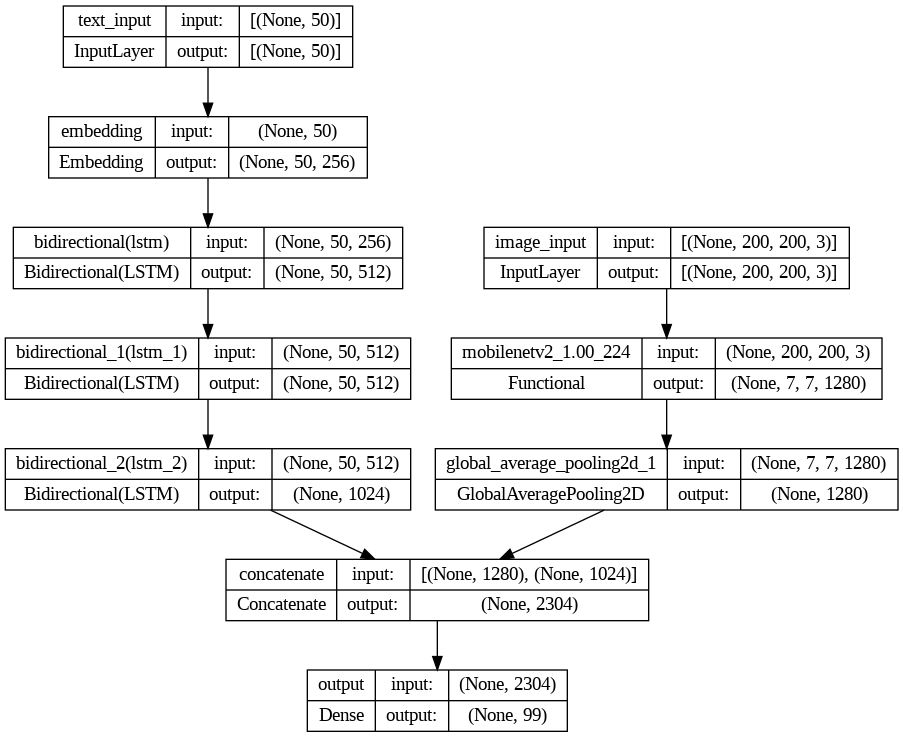

In [7]:
img_file1 = '/content/model-1.png'
tf.keras.utils.plot_model(model1, to_file=img_file1, show_shapes=True)

In [10]:
tf.random.set_seed(1)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, TensorBoard

In [ ]:
mc = ModelCheckpoint(mode='max', filepath='/content/Model-1_B50.h5', monitor='val_sparse_categorical_accuracy',save_best_only='True', save_weights_only='True', verbose=1)

In [ ]:
def scheduler(epoch):
  if epoch < 1:
    return 0.001
  else:
    return 0.001 * tf.math.exp(0.1 * (1 - epoch))

LRS = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
csv_callback=tf.keras.callbacks.CSVLogger(
    "Training Parameters-1_B50.csv", separator=',', append=False
)

In [11]:
model1.load_weights('/content/Model-1_B50.h5')

In [2]:
history = model1.fit(train_dataset,
          validation_data= validation_dataset,
          epochs=10,
          callbacks=[mc,LRS,csv_callback] 
         )

MODEL - 1 Evaluation and Results

Predictions Are as follows = 
(320, 480, 3)
(200, 200, 3)
(50,)
1/1 [==============================] - 14s 14s/step
(320, 480, 3)
(200, 200, 3)
(50,)
1/1 [==============================] - 0s 46ms/step
(320, 480, 3)
(200, 200, 3)
(50,)
1/1 [==============================] - 0s 68ms/step
(320, 480, 3)
(200, 200, 3)
(50,)
1/1 [==============================] - 0s 65ms/step
(320, 480, 3)
(200, 200, 3)
(50,)
1/1 [==============================] - 0s 53ms/step


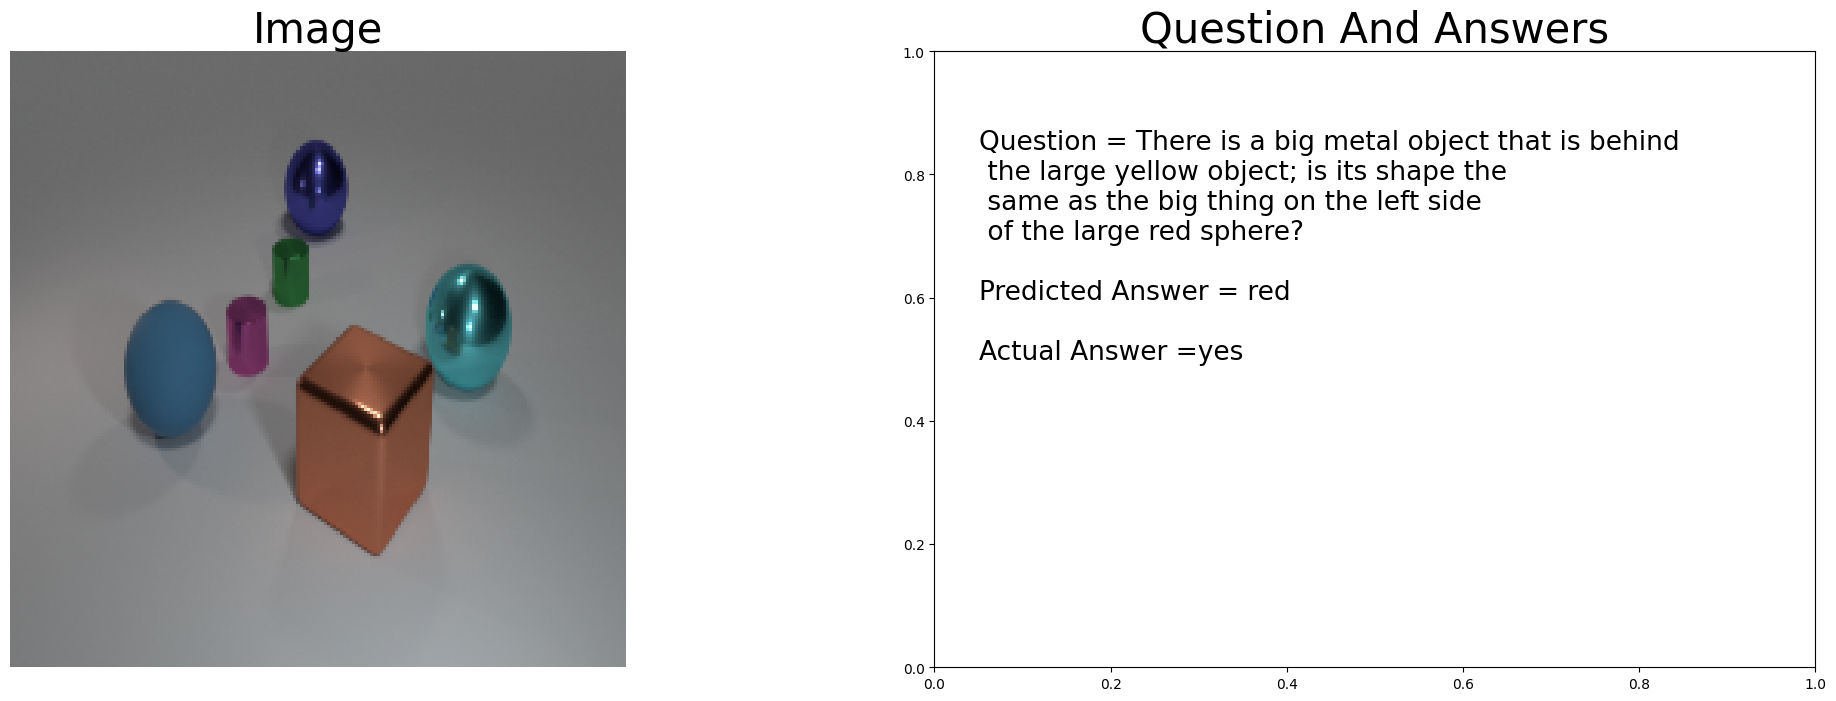

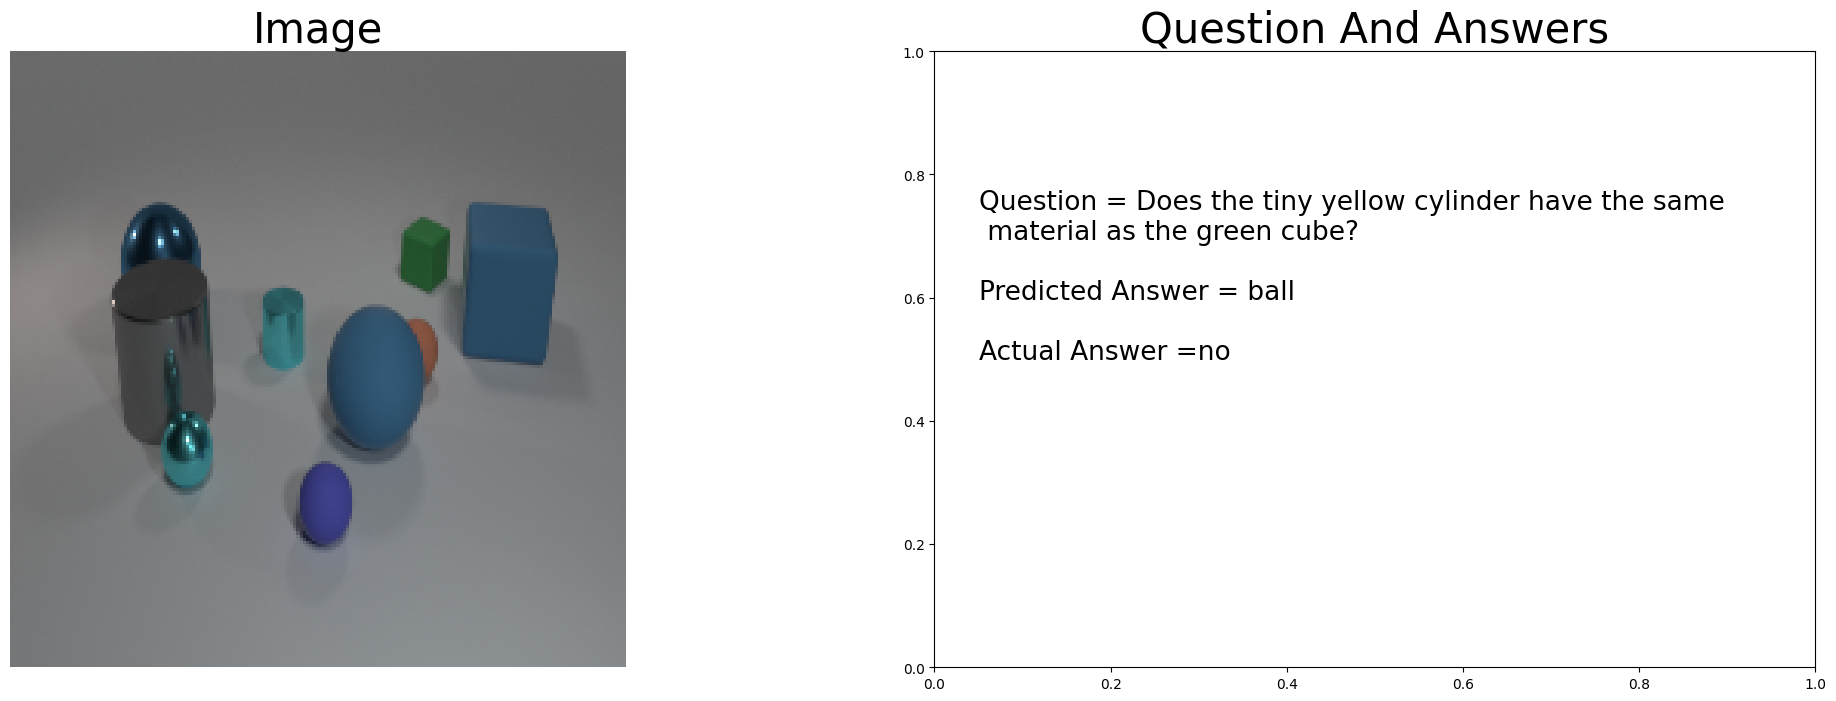

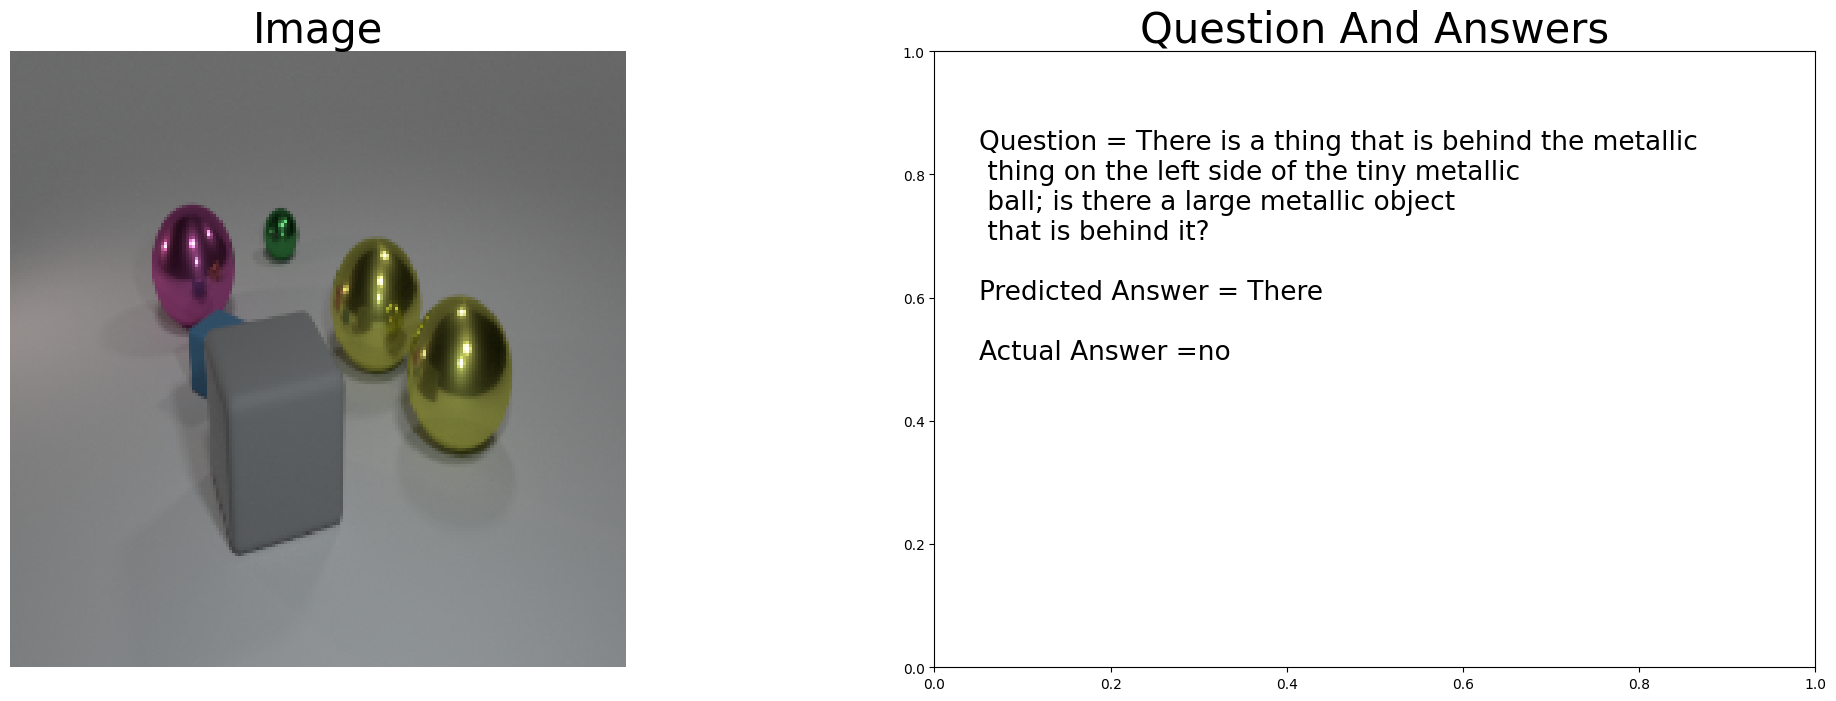

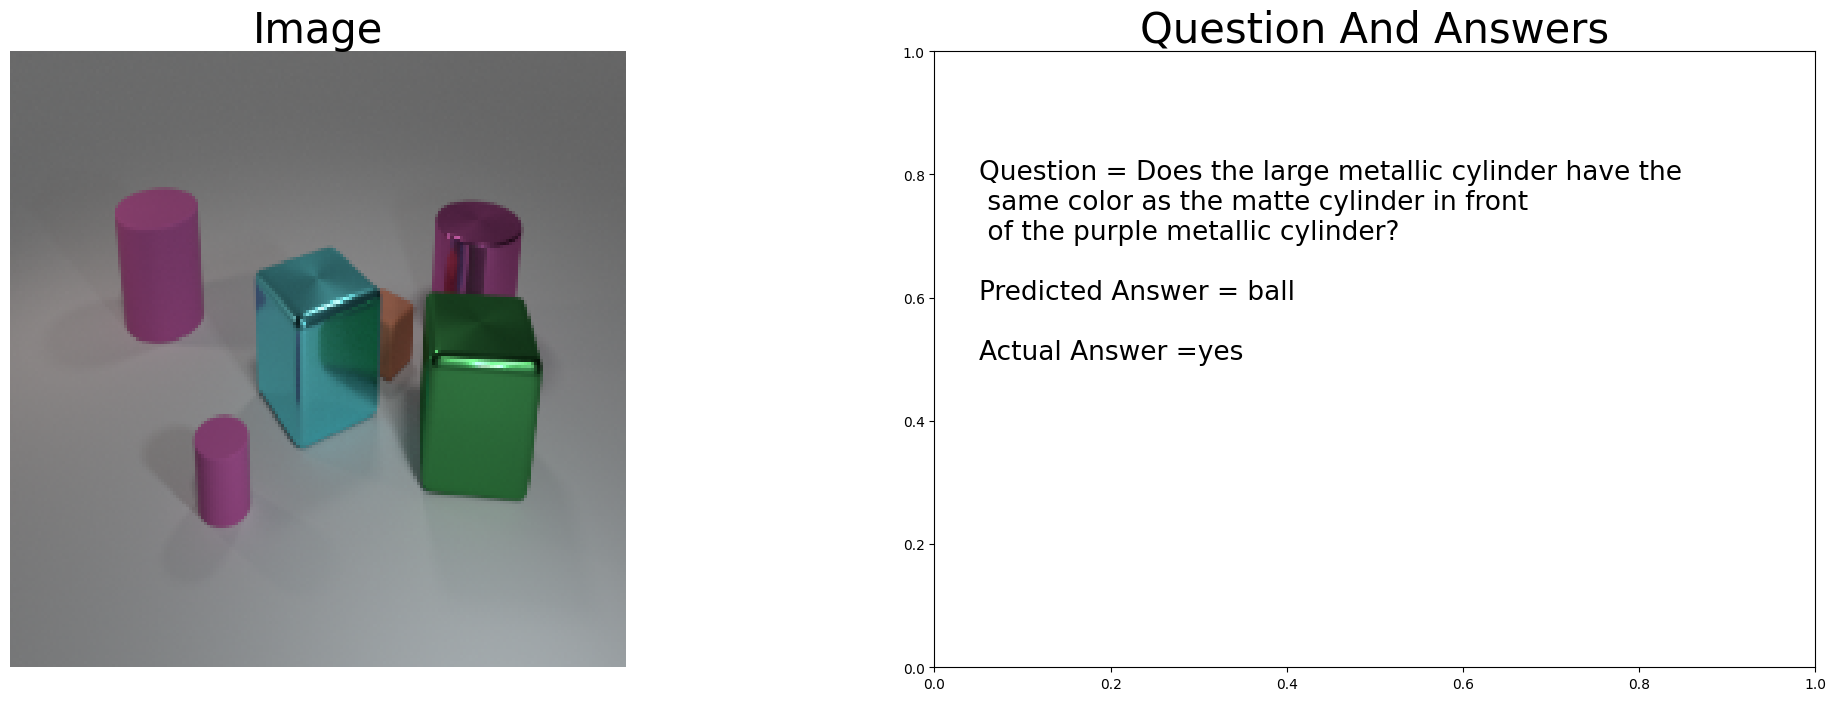

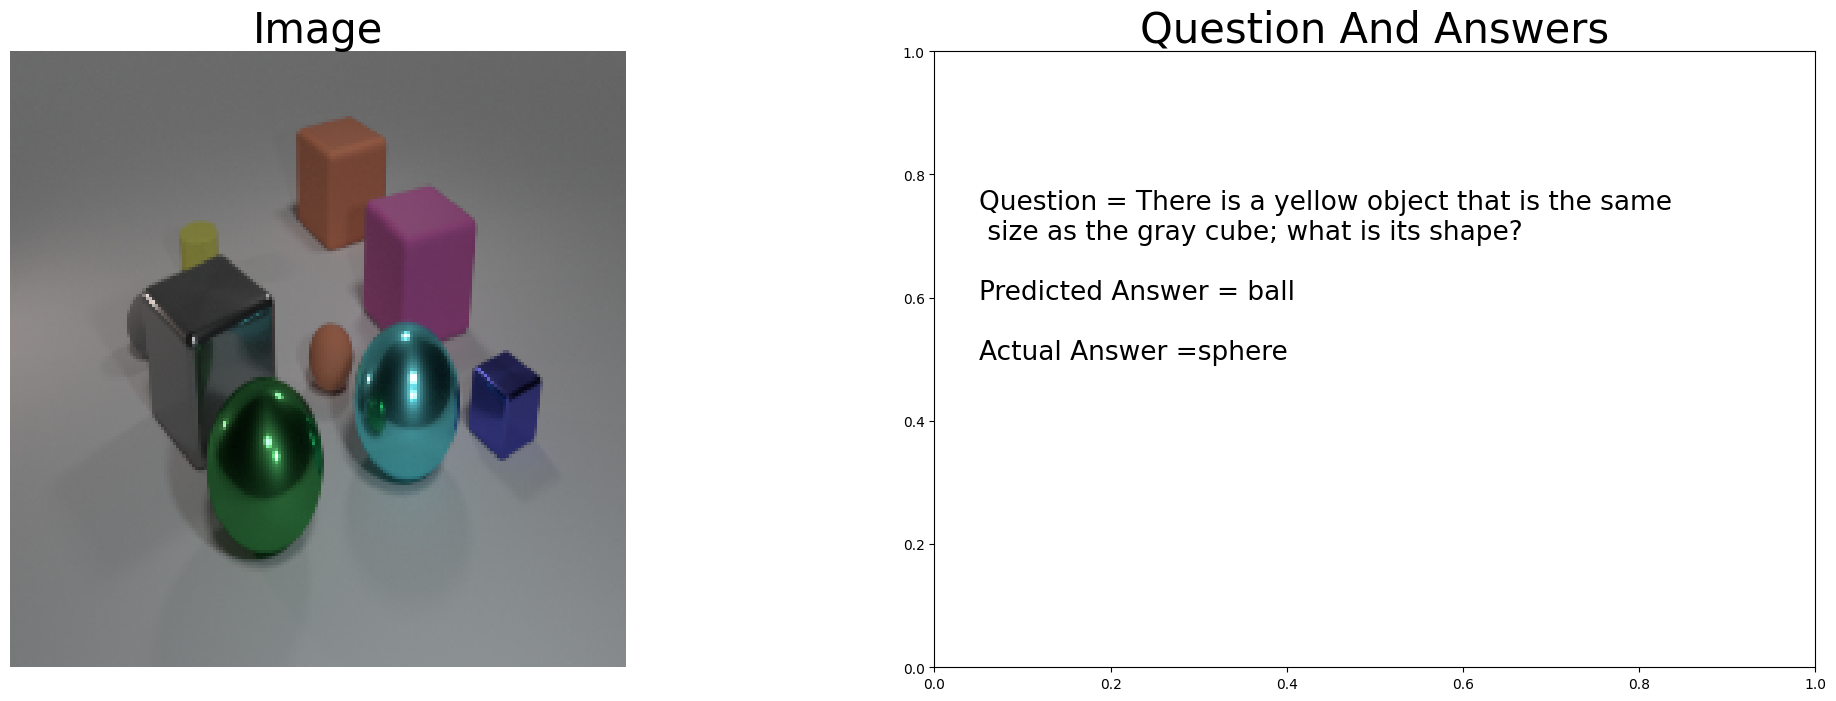

In [14]:
print("Predictions Are as follows = ")

for i in range(5):
    index=random.randrange(5000)
    fig,axis=plt.subplots(1,2,figsize=(25, 8))
    im=cv2.imread(val_dataframe.iloc[index]['Path'])
    print(im.shape)
    im=cv2.resize(im,(200,200))
    q=val_dataframe.iloc[index]['Question']
    q=encoder.encode(q)
    paddings = [[0, 50-tf.shape(q)[0]]]
    q=tf.pad(q, paddings, 'CONSTANT', constant_values=0)
    q=np.array(q)
    print(im.shape)
    print(q.shape)
    im = np.expand_dims(im, axis=0)  # Add an extra dimension for batch size
    q = np.expand_dims(q, axis=0)  # Add an extra dimension for batch size
    inp = [im, q]
    ans = model1.predict(inp)
    question=""
    flag=0
    for i,j in enumerate(val_dataframe.iloc[index]['Question']):
        if (flag==1) and (j==' '):
            question+='\n'
            flag=0
        question+=j
        if (i%40==0)and (i!=0):
            flag=1
    axis[0].imshow(im[0])  # Remove the extra dimension before showing the image
    axis[0].axis('off')
    axis[0].set_title('Image', fontsize=30)
    axis[1].text(0.05,0.5,
             "Question = {}\n\nPredicted Answer = {}\n\nActual Answer ={}".format(question,encoder.decode([np.argmax(ans)]),val_dataframe.iloc[index]['Answer']),
             transform=plt.gca().transAxes,fontsize=19)
    axis[1].axis('on')
    axis[1].set_title('Question And Answers', fontsize=30)

In [15]:
print("Predictions Are as follows = ")
df = pd.read_csv("/content/Training Parameters-1_B50.csv")
df.tail()

Predictions Are as follows = 


epoch      loss        lr  sparse_categorical_accuracy  val_loss  \
5      5  1.010296  0.000670                      0.44810  1.124823   
6      6  0.984417  0.000607                      0.46710  1.183506   
7      7  0.967120  0.000549                      0.48380  1.046904   
8      8  0.950974  0.000497                      0.49615  1.060585   
9      9  0.942206  0.000449                      0.51030  1.144921   

   val_sparse_categorical_accuracy  
5                           0.4326  
6                           0.4174  
7                           0.4312  
8                           0.4402  
9                           0.4310

In [16]:
X = df['epoch']

font = {'size': 10}
plt.rc('font', **font)

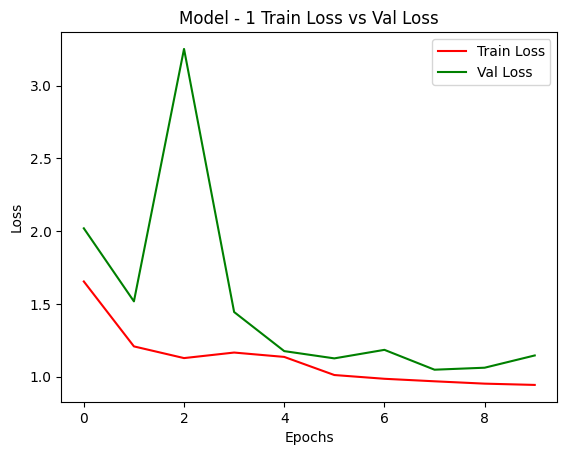

In [17]:
y = df['loss']
z = df['val_loss']
  
plt.plot(X, y, color='r', label='Train Loss')
plt.plot(X, z, color='g', label='Val Loss')
  
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model - 1 Train Loss vs Val Loss")
  
plt.legend()
  
plt.show()

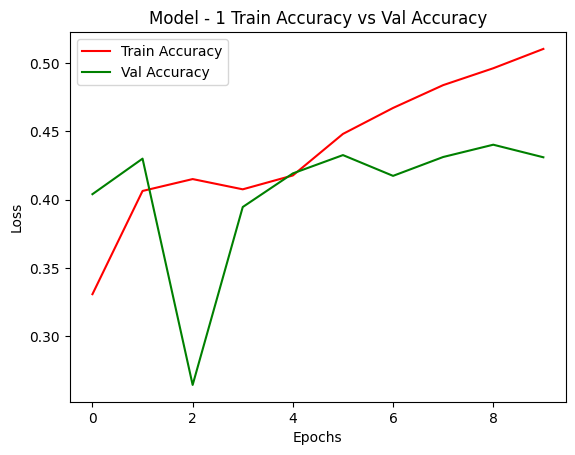

In [18]:
y = df['sparse_categorical_accuracy']
z = df['val_sparse_categorical_accuracy']
  
plt.plot(X, y, color='r', label='Train Accuracy')
plt.plot(X, z, color='g', label='Val Accuracy')
  
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model - 1 Train Accuracy vs Val Accuracy")
  
plt.legend()
  
plt.show()

MODEL - 2: VGG-16 + Transformer

In [19]:
BATCH_SIZE=50
IMG_SIZE=(224,224)


#Function that uses the encoder created to encode the input question and answer string
def encode_fn(text):
    return np.array(encoder.encode(text.numpy()))


#Function to load and decode the image from the file paths in the dataframe and use the encoder function
def preprocess(ip,ans):
    img,ques=ip#ip is a list containing image paths and questions
    img=tf.io.read_file(img)
    img=tf.image.decode_jpeg(img,channels=3)
    # quantos canais de cores tem 
    img=tf.image.resize(img,IMG_SIZE)
    img=tf.math.divide(img, 255)# 
    #The question string is converted to encoded list with fixed size of 50 with padding with 0 value
    ques=tf.py_function(encode_fn,inp=[ques],Tout=tf.int32)
    paddings = [[0, 50-tf.shape(ques)[0]]]
    ques = tf.pad(ques, paddings, 'CONSTANT', constant_values=0)
    ques.set_shape([50])#Explicit shape must be defined in order to create the Input pipeline
    
    #The Answer is also encoded 
    ans=tf.py_function(encode_fn,inp=[ans],Tout=tf.int32)
    ans.set_shape([1])
    
    return (img,ques),ans
    
def create_pipeline(dataframe):
    raw_df=tf.data.Dataset.from_tensor_slices(((dataframe['Path'],dataframe['Question']),dataframe['Answer']))
    df=raw_df.map(preprocess)#Preprocessing function is applied to the dataset
    df=df.batch(BATCH_SIZE)#The dataset is batched
    return df

#The training and validation Dataset objects are created
train_dataset=create_pipeline(train_dataframe)
validation_dataset=create_pipeline(val_dataframe)

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D

def vgg16_encoder():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    return model


In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers import MultiHeadAttention, Bidirectional, LSTM


def transformer_encoder(input_shape, vocab_size, num_layers, embedding_dim, num_heads, 
                        feed_forward_dim, dropout_rate):
    inputs = Input(shape=input_shape,name='text_input')
    x = Embedding(vocab_size, embedding_dim)(inputs)
    
    for i in range(num_layers):
        # Multi-Head Attention
        multi_head_output = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)(x, x)
        # Add and Normalize
        x = LayerNormalization(epsilon=1e-6)(x + multi_head_output)
        
        # Feed-Forward
        ff_output = Dense(feed_forward_dim, activation='relu')(x)
        ff_output = Dropout(dropout_rate)(ff_output)
        ff_output = Dense(embedding_dim)(ff_output)
        # Add and Normalize
        x = LayerNormalization(epsilon=1e-6)(x + ff_output)
        
    # Global Average Pooling
    x = GlobalAveragePooling1D()(x)
    
    # LSTM Layer
    # x = Bidirectional(LSTM(embedding_dim))(x)
    
    #outputs = Dense(embedding_dim, activation='tanh')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=x)
    return model,inputs

In [10]:
#Creating the CNN model for image processing
CNN_Input=tf.keras.layers.Input(shape=(224,224,3),name='image_input')
vgg = vgg16_encoder()
CNN_model=tf.keras.models.Sequential()
CNN_model.add(CNN_Input)
CNN_model.add(vgg)
CNN_model.add(tf.keras.layers.GlobalAveragePooling2D())

RNN_model,RNN_Input = transformer_encoder(50, len(vocab_set), 5, 50, 3, 256, 0.2)

concat=tf.keras.layers.concatenate([CNN_model.output,RNN_model.output])
dense_out=tf.keras.layers.Dense(len(vocab_set),activation='softmax',name='output')(concat)

model2 = tf.keras.Model(inputs=[CNN_Input,RNN_Input], outputs=dense_out)
model2.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 50)]         0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 50, 50)       4950        ['text_input[0][0]']             
                                                                                                  
 multi_head_attention (MultiHea  (None, 50, 50)      30500       ['embedding_1[0][0]',            
 dAttention)                                                      'embedding_1[0][0]']            
                                                                                                  
 tf.__operators__.add (TFOpLamb  (None, 50, 50)      0           ['embedding_1[0][0]',      

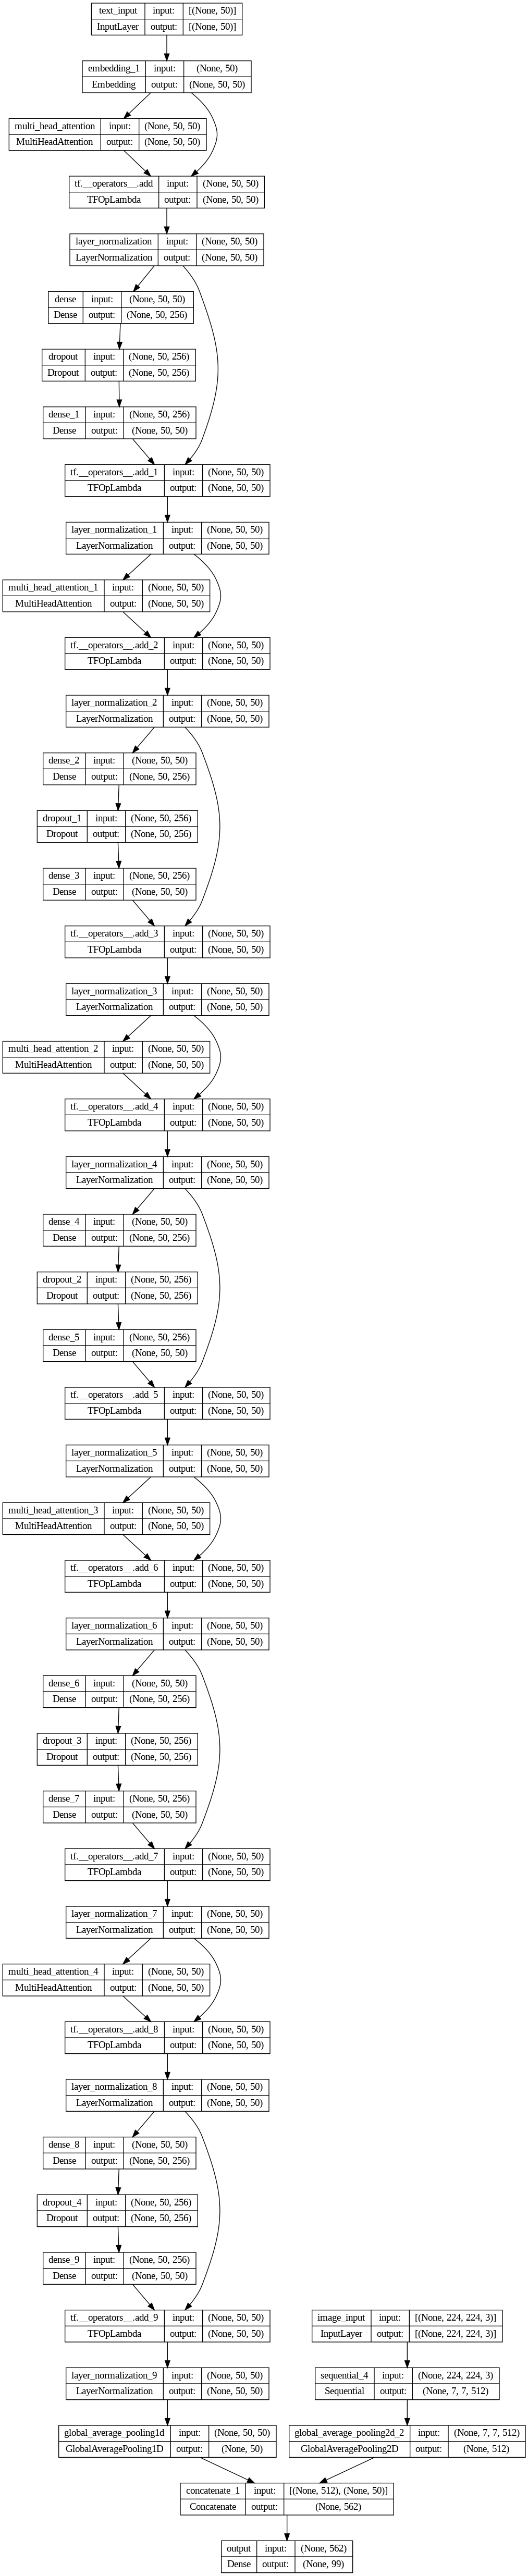

In [11]:
img_file2 = '/content/model-2.png'
tf.keras.utils.plot_model(model2, to_file=img_file2, show_shapes=True)

In [23]:
tf.random.set_seed(1)

In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, TensorBoard

In [ ]:
mc = ModelCheckpoint(mode='max', filepath='/content/Model-2_B50.h5', monitor='val_sparse_categorical_accuracy',save_best_only='True', save_weights_only='True', verbose=1)

In [ ]:
def scheduler(epoch):
  if epoch < 1:
    return 0.001
  else:
    return 0.001 * tf.math.exp(0.1 * (1 - epoch))

LRS = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
csv_callback=tf.keras.callbacks.CSVLogger(
    "Training Parameters-2_B50.csv", separator=',', append=False
)

In [ ]:
model2.load_weights('/content/Model-2_B50.h5')

In [2]:
history = model2.fit(train_dataset,
          validation_data= validation_dataset,
          epochs=10,
          callbacks=[mc,csv_callback,LRS] 
         )

MODEL - 2 Evaluation and Results

Predictions Are as follows = 
(320, 480, 3)
(224, 224, 3)
(50,)
1/1 [==============================] - 0s 37ms/step
(320, 480, 3)
(224, 224, 3)
(50,)
1/1 [==============================] - 0s 41ms/step
(320, 480, 3)
(224, 224, 3)
(50,)
1/1 [==============================] - 0s 44ms/step
(320, 480, 3)
(224, 224, 3)
(50,)
1/1 [==============================] - 0s 39ms/step
(320, 480, 3)
(224, 224, 3)
(50,)
1/1 [==============================] - 0s 39ms/step


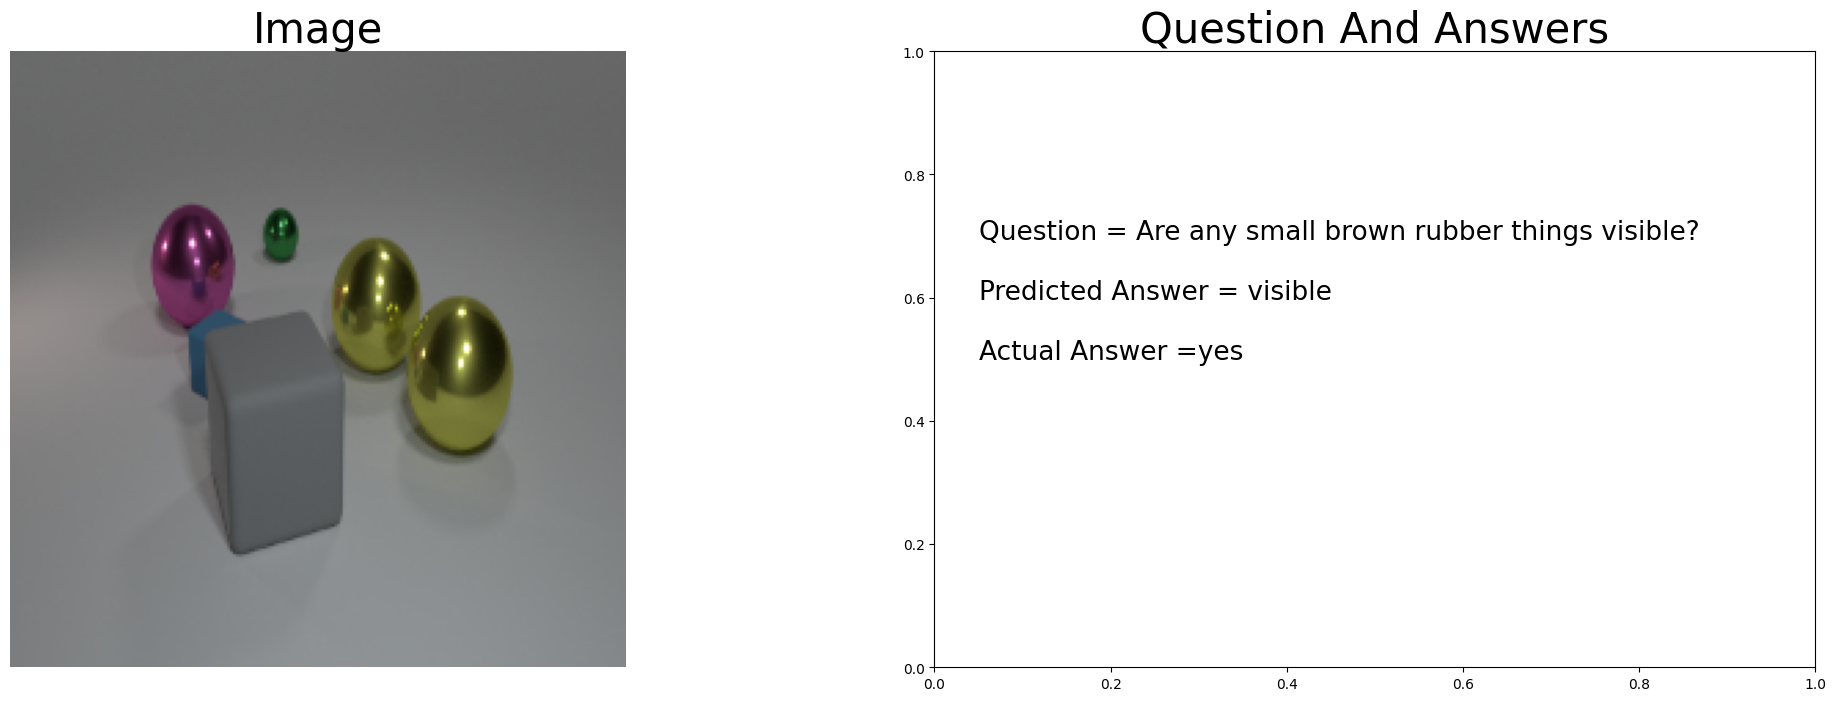

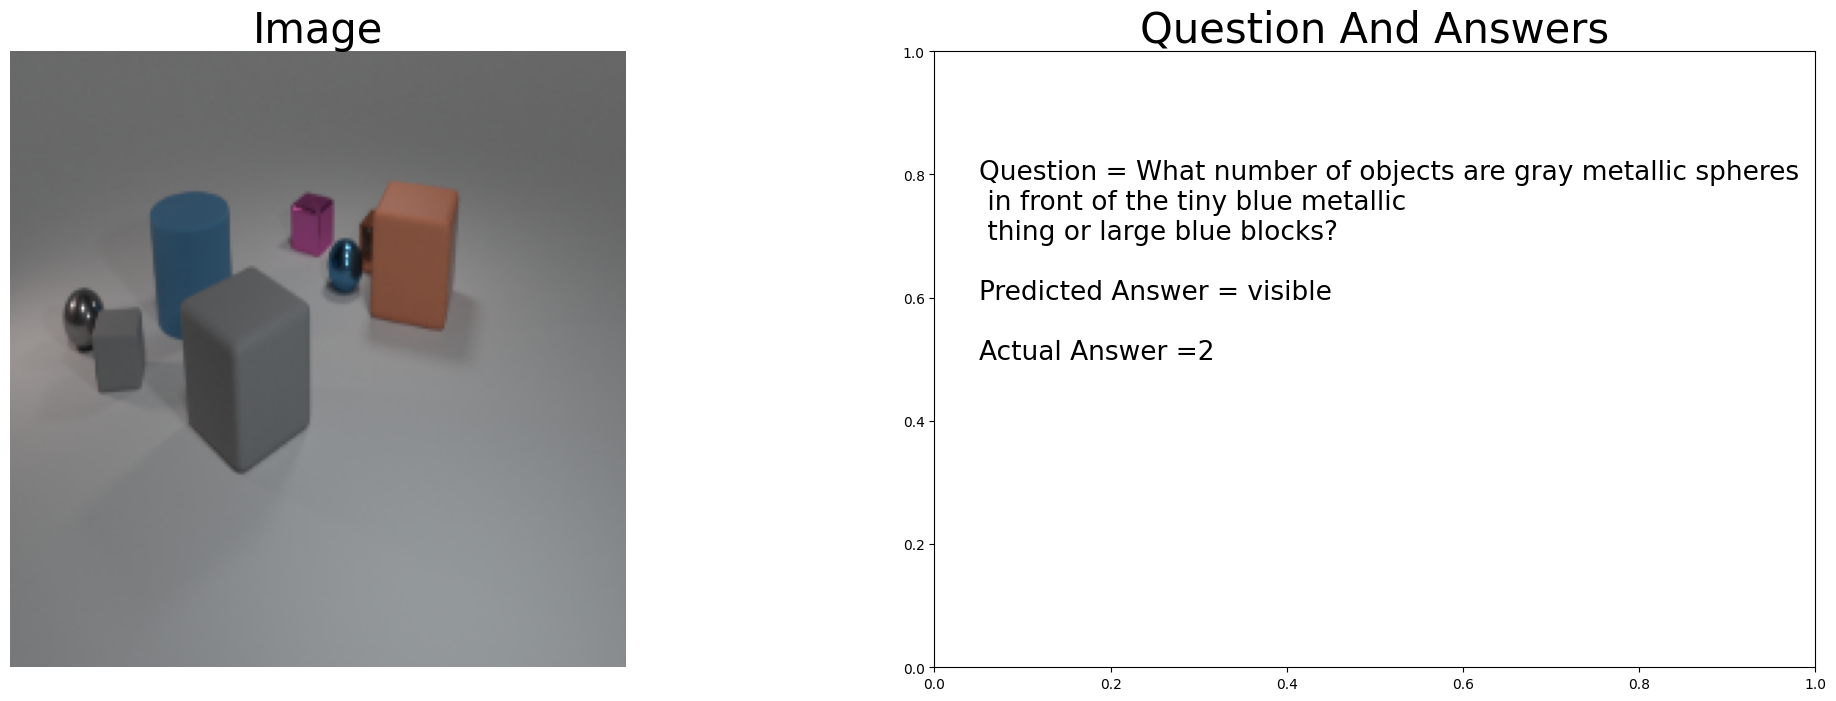

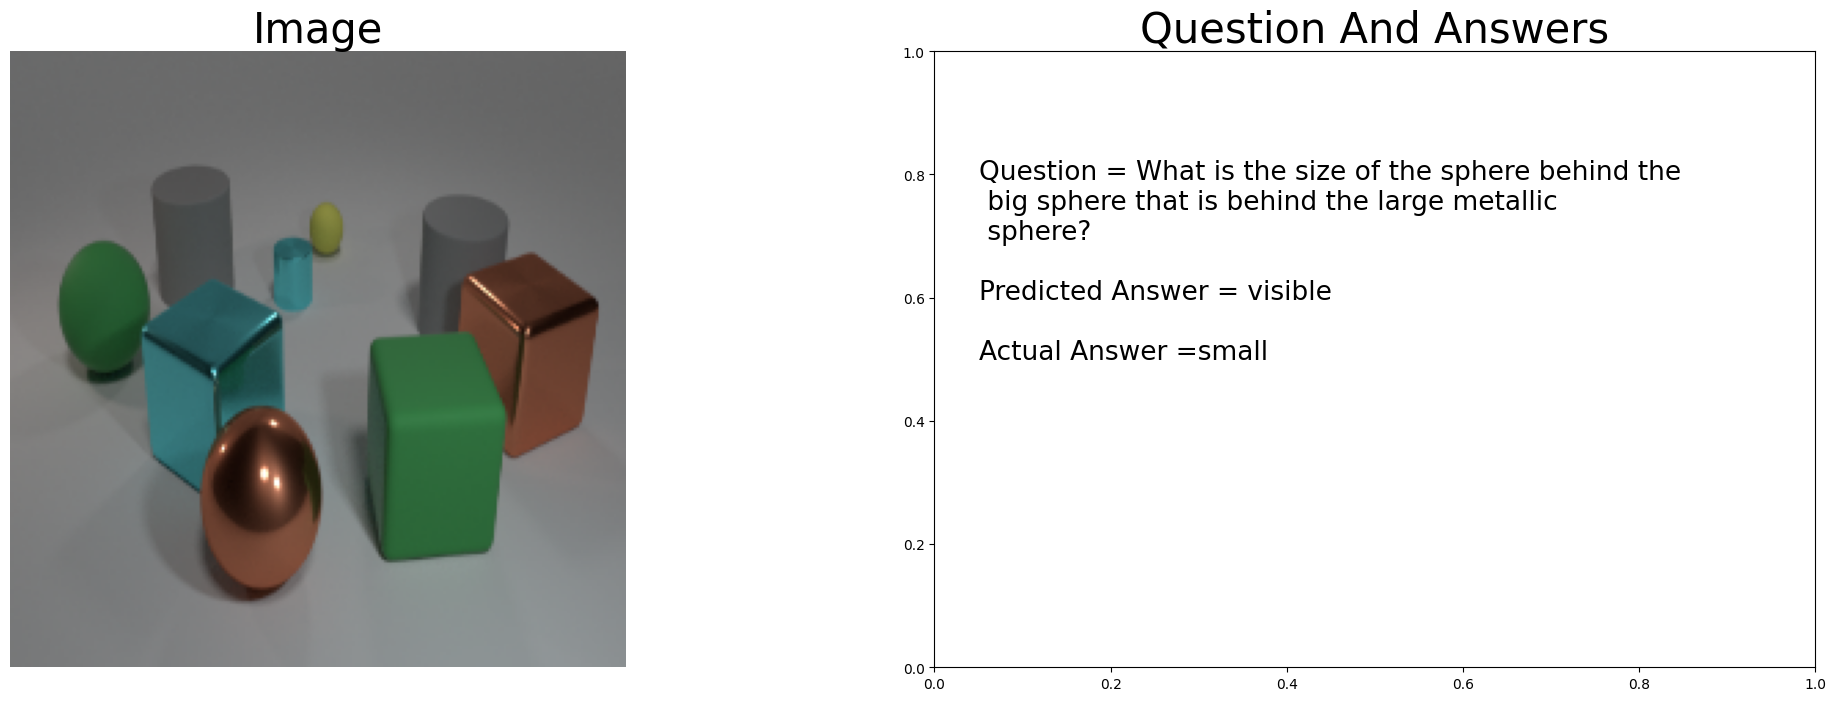

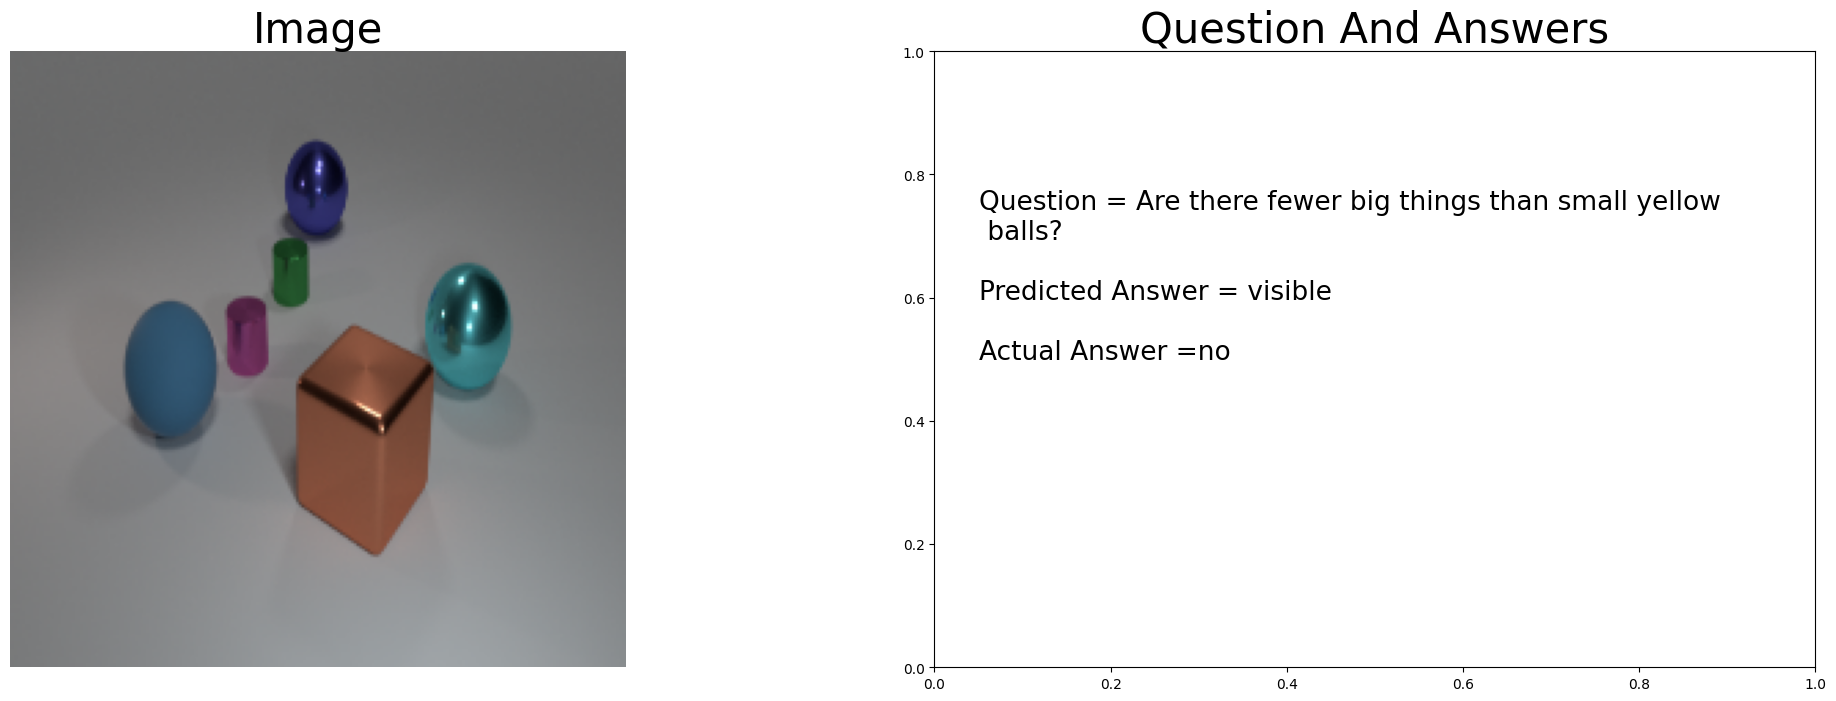

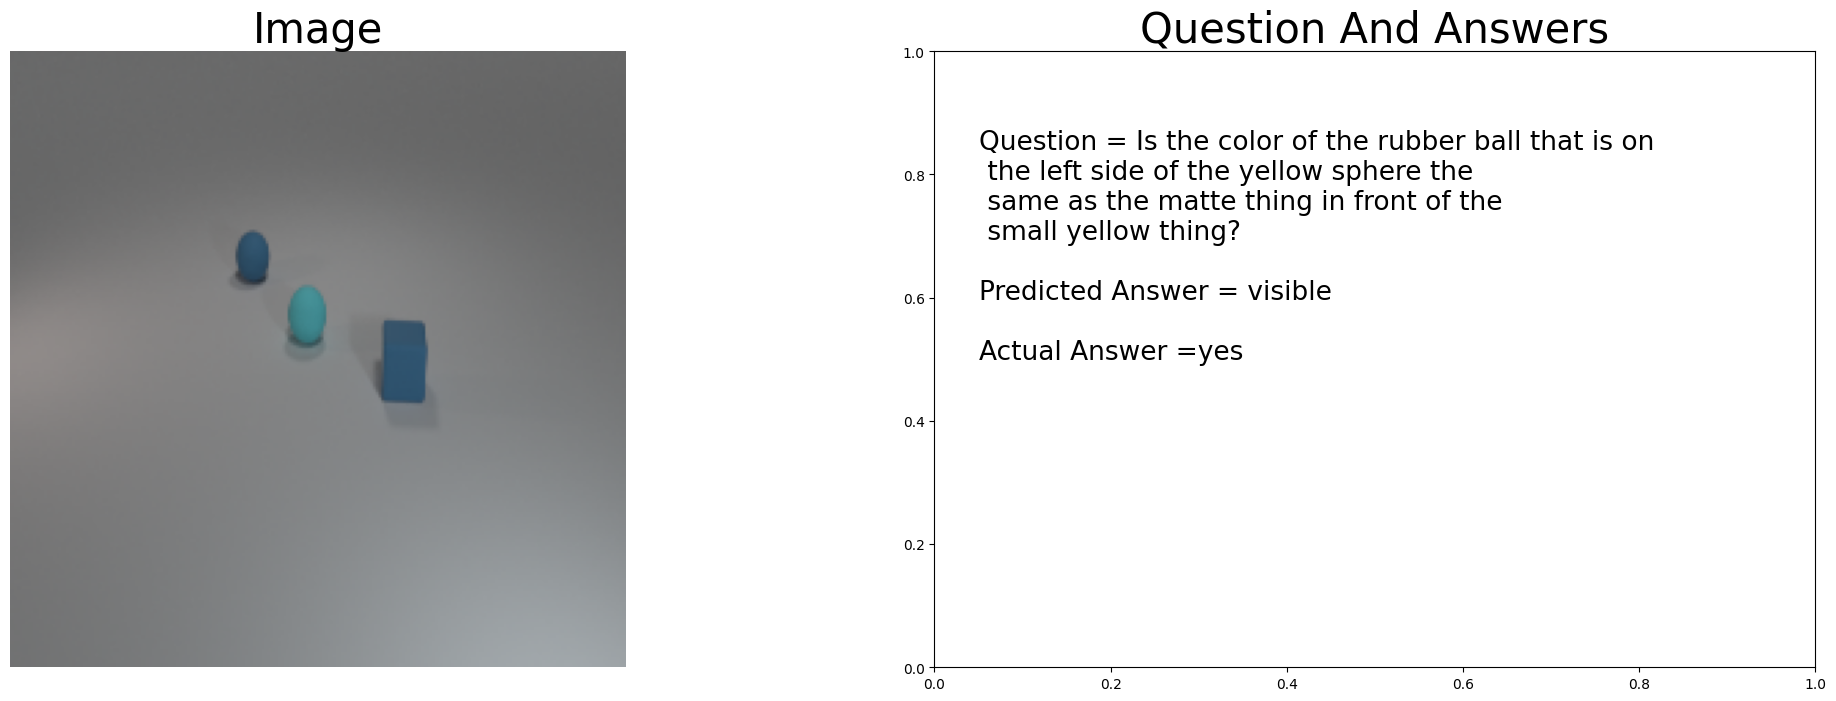

In [28]:
print("Predictions Are as follows = ")

for i in range(5):
    index=random.randrange(5000)
    fig,axis=plt.subplots(1,2,figsize=(25, 8))
    im=cv2.imread(val_dataframe.iloc[index]['Path'])
    print(im.shape)
    im=cv2.resize(im,(224,224))
    q=val_dataframe.iloc[index]['Question']
    q=encoder.encode(q)
    paddings = [[0, 50-tf.shape(q)[0]]]
    q=tf.pad(q, paddings, 'CONSTANT', constant_values=0)
    q=np.array(q)
    print(im.shape)
    print(q.shape)
    im = np.expand_dims(im, axis=0)  # Add an extra dimension for batch size
    q = np.expand_dims(q, axis=0)  # Add an extra dimension for batch size
    inp = [im, q]
    ans = model2.predict(inp)
    question=""
    flag=0
    for i,j in enumerate(val_dataframe.iloc[index]['Question']):
        if (flag==1) and (j==' '):
            question+='\n'
            flag=0
        question+=j
        if (i%40==0)and (i!=0):
            flag=1
    axis[0].imshow(im[0])  # Remove the extra dimension before showing the image
    axis[0].axis('off')
    axis[0].set_title('Image', fontsize=30)
    axis[1].text(0.05,0.5,
             "Question = {}\n\nPredicted Answer = {}\n\nActual Answer ={}".format(question,encoder.decode([np.argmax(ans)]),val_dataframe.iloc[index]['Answer']),
             transform=plt.gca().transAxes,fontsize=19)
    axis[1].axis('on')
    axis[1].set_title('Question And Answers', fontsize=30)

In [30]:
print("Predictions Are as follows = ")
df1 = pd.read_csv("/content/Training Parameters-2_B50.csv")
df1.tail()


Predictions Are as follows = 


epoch      loss  sparse_categorical_accuracy  val_loss  \
5      5  1.557141                      0.33160  1.516323   
6      6  1.503266                      0.34955  1.354969   
7      7  1.325052                      0.38665  1.278708   
8      8  1.236405                      0.39715  1.191673   
9      9  1.208019                      0.39865  1.177693   

   val_sparse_categorical_accuracy  
5                           0.3650  
6                           0.4098  
7                           0.4040  
8                           0.4128  
9                           0.4136

In [31]:
X = df1['epoch']

font = {'size': 10}
plt.rc('font', **font)

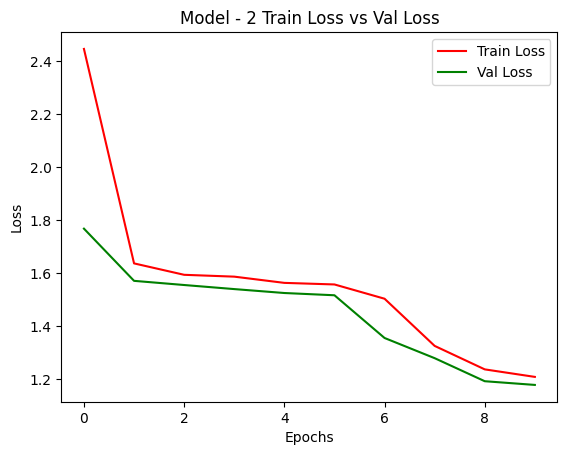

In [32]:
y = df1['loss']
z = df1['val_loss']
  
plt.plot(X, y, color='r', label='Train Loss')
plt.plot(X, z, color='g', label='Val Loss')
  
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model - 2 Train Loss vs Val Loss")
  
plt.legend()
  
plt.show()

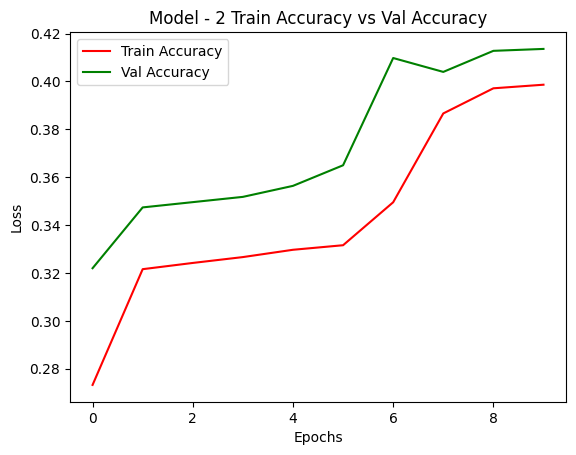

In [33]:
y = df1['sparse_categorical_accuracy']
z = df1['val_sparse_categorical_accuracy']
  
plt.plot(X, y, color='r', label='Train Accuracy')
plt.plot(X, z, color='g', label='Val Accuracy')
  
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model - 2 Train Accuracy vs Val Accuracy")
  
plt.legend()
  
plt.show()

MODEL - 3: VGG-16 + Bi-Directional LSTM

In [34]:
BATCH_SIZE=50
IMG_SIZE=(224,224)


#Function that uses the encoder created to encode the input question and answer string
def encode_fn(text):
    return np.array(encoder.encode(text.numpy()))


#Function to load and decode the image from the file paths in the dataframe and use the encoder function
def preprocess(ip,ans):
    img,ques=ip#ip is a list containing image paths and questions
    img=tf.io.read_file(img)
    img=tf.image.decode_jpeg(img,channels=3)
    # quantos canais de cores tem 
    img=tf.image.resize(img,IMG_SIZE)
    img=tf.math.divide(img, 255)# 
    #The question string is converted to encoded list with fixed size of 50 with padding with 0 value
    ques=tf.py_function(encode_fn,inp=[ques],Tout=tf.int32)
    paddings = [[0, 50-tf.shape(ques)[0]]]
    ques = tf.pad(ques, paddings, 'CONSTANT', constant_values=0)
    ques.set_shape([50])#Explicit shape must be defined in order to create the Input pipeline
    
    #The Answer is also encoded 
    ans=tf.py_function(encode_fn,inp=[ans],Tout=tf.int32)
    ans.set_shape([1])
    
    return (img,ques),ans
    
def create_pipeline(dataframe):
    raw_df=tf.data.Dataset.from_tensor_slices(((dataframe['Path'],dataframe['Question']),dataframe['Answer']))
    df=raw_df.map(preprocess)#Preprocessing function is applied to the dataset
    df=df.batch(BATCH_SIZE)#The dataset is batched
    return df

#The training and validation Dataset objects are created
train_dataset=create_pipeline(train_dataframe)
validation_dataset=create_pipeline(val_dataframe)

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D

def vgg16_encoder():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    return model


In [13]:
#Creating the CNN model for image processing
CNN_Input=tf.keras.layers.Input(shape=(224,224,3),name='image_input')
vgg = vgg16_encoder()
CNN_model=tf.keras.models.Sequential()
CNN_model.add(CNN_Input)
CNN_model.add(vgg)
CNN_model.add(tf.keras.layers.GlobalAveragePooling2D())



#Creating the RNN model for text processing
RNN_model=tf.keras.models.Sequential()

RNN_Input=tf.keras.layers.Input(shape=(50),name='text_input')
RNN_model.add(RNN_Input)
RNN_model.add(tf.keras.layers.Embedding (len(vocab_set)+1,256))
RNN_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256,stateful=False,return_sequences=True,recurrent_initializer='glorot_uniform')))
RNN_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256,stateful=False,return_sequences=True,recurrent_initializer='glorot_uniform')))
RNN_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512,stateful=False,return_sequences=False,recurrent_initializer='glorot_uniform')))


concat=tf.keras.layers.concatenate([CNN_model.output,RNN_model.output])
dense_out=tf.keras.layers.Dense(len(vocab_set),activation='softmax',name='output')(concat)

model3 = tf.keras.Model(inputs=[CNN_Input,RNN_Input], outputs=dense_out)
model3.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
model3.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 50)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 50, 256)      25600       ['text_input[0][0]']             
                                                                                                  
 image_input (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 bidirectional_3 (Bidirectional  (None, 50, 512)     1050624     ['embedding_2[0][0]']      

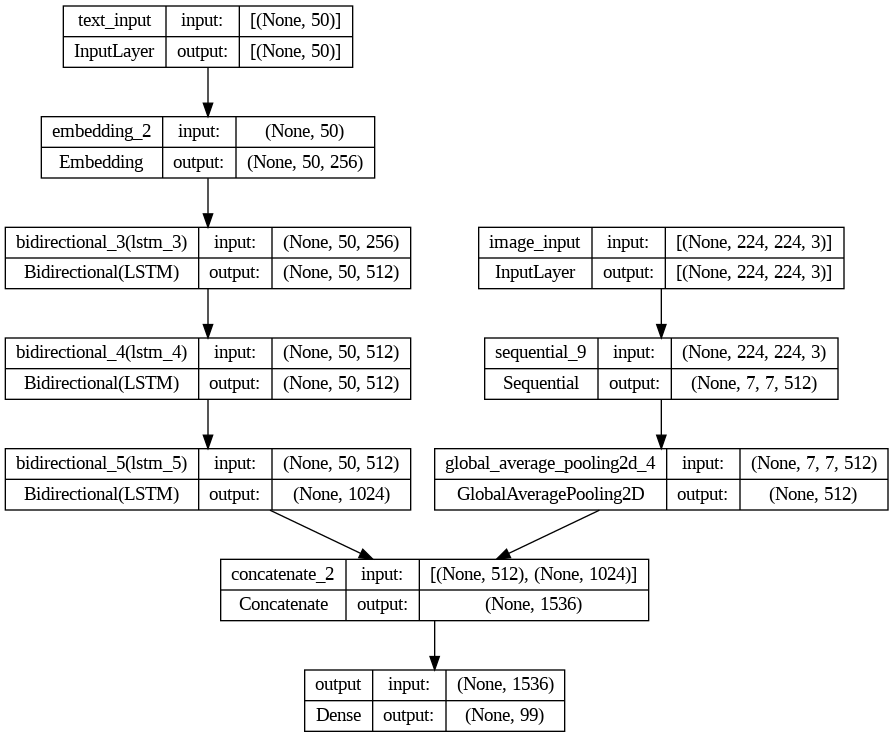

In [14]:
img_file3 = '/content/model-3.png'
tf.keras.utils.plot_model(model3, to_file=img_file3, show_shapes=True)

In [37]:
tf.random.set_seed(1)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, TensorBoard

In [ ]:
mc = ModelCheckpoint(mode='max', filepath='/content/Model-3_B50.h5', monitor='val_sparse_categorical_accuracy',save_best_only='True', save_weights_only='True', verbose=1)

In [ ]:
def scheduler(epoch):
  if epoch < 1:
    return 0.0001
  else:
    return 0.0001 * tf.math.exp(0.1 * (1 - epoch))

LRS = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
csv_callback=tf.keras.callbacks.CSVLogger(
    "Training Parameters-3_B50.csv", separator=',', append=False
)

In [38]:
model3.load_weights('/content/Model-3_B50.h5')

In [2]:
history = model3.fit(train_dataset,
          validation_data= validation_dataset,
          epochs=10,
          callbacks=[mc,LRS,csv_callback] 
         )

MODEL - 3 Evaluation and Results

Predictions Are as follows = 
(320, 480, 3)
(224, 224, 3)
(50,)
1/1 [==============================] - 0s 30ms/step
(320, 480, 3)
(224, 224, 3)
(50,)
1/1 [==============================] - 0s 36ms/step
(320, 480, 3)
(224, 224, 3)
(50,)
1/1 [==============================] - 0s 29ms/step
(320, 480, 3)
(224, 224, 3)
(50,)
1/1 [==============================] - 0s 36ms/step
(320, 480, 3)
(224, 224, 3)
(50,)
1/1 [==============================] - 0s 27ms/step


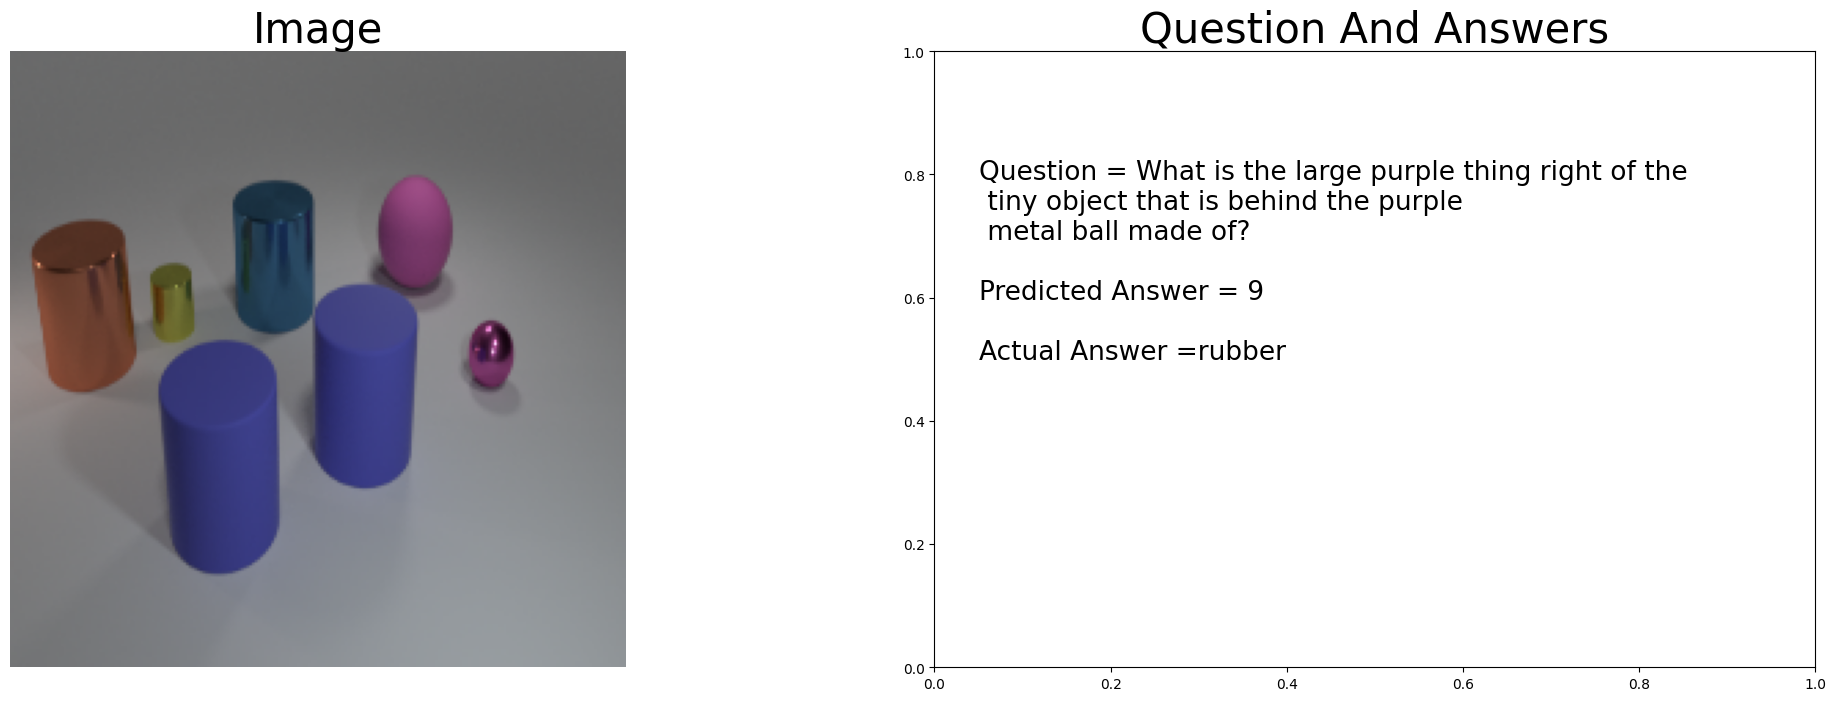

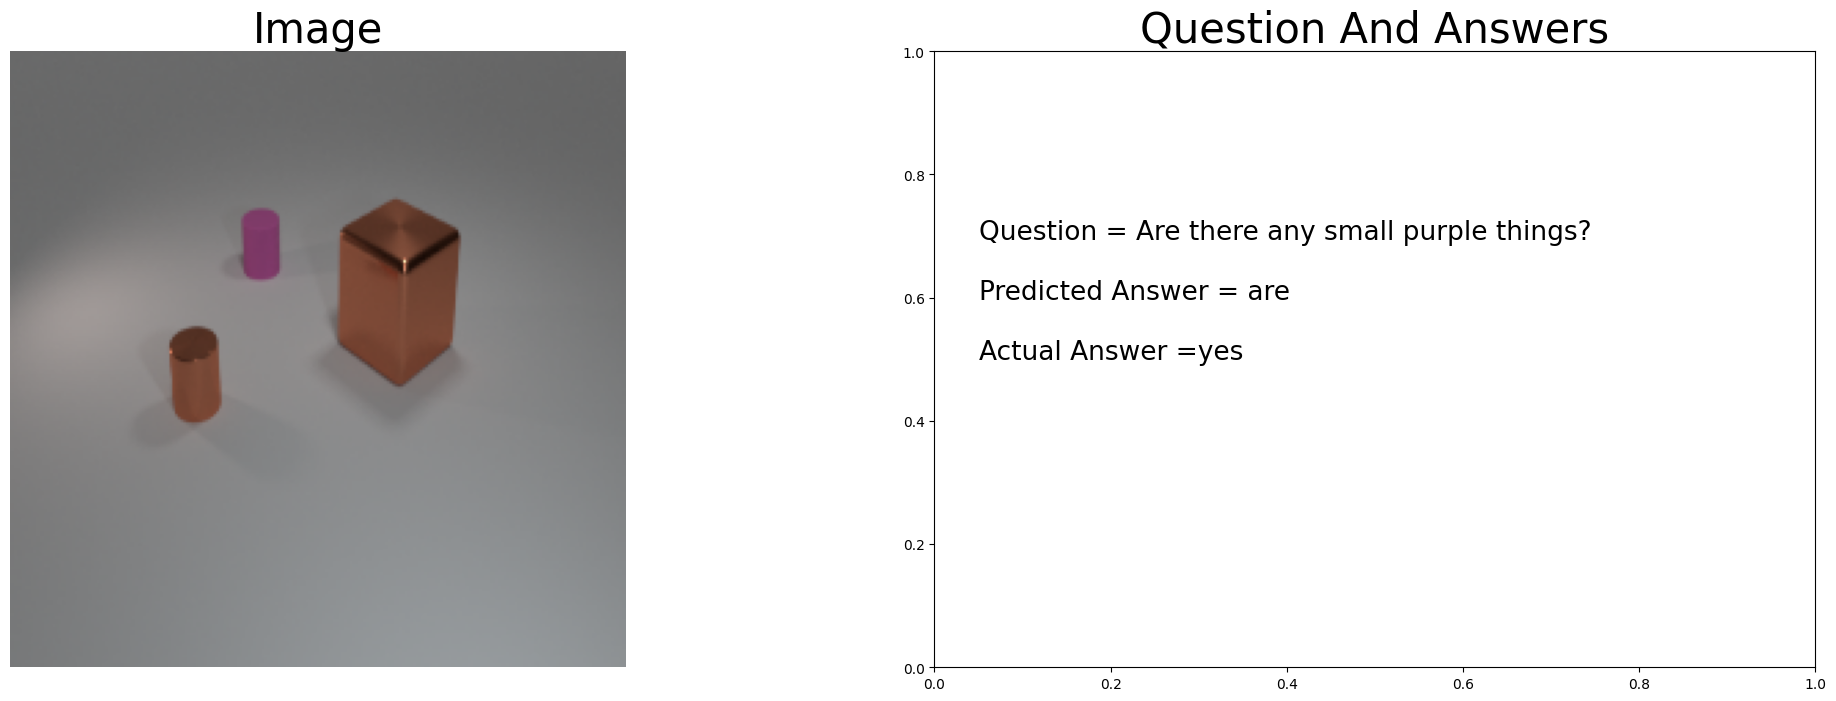

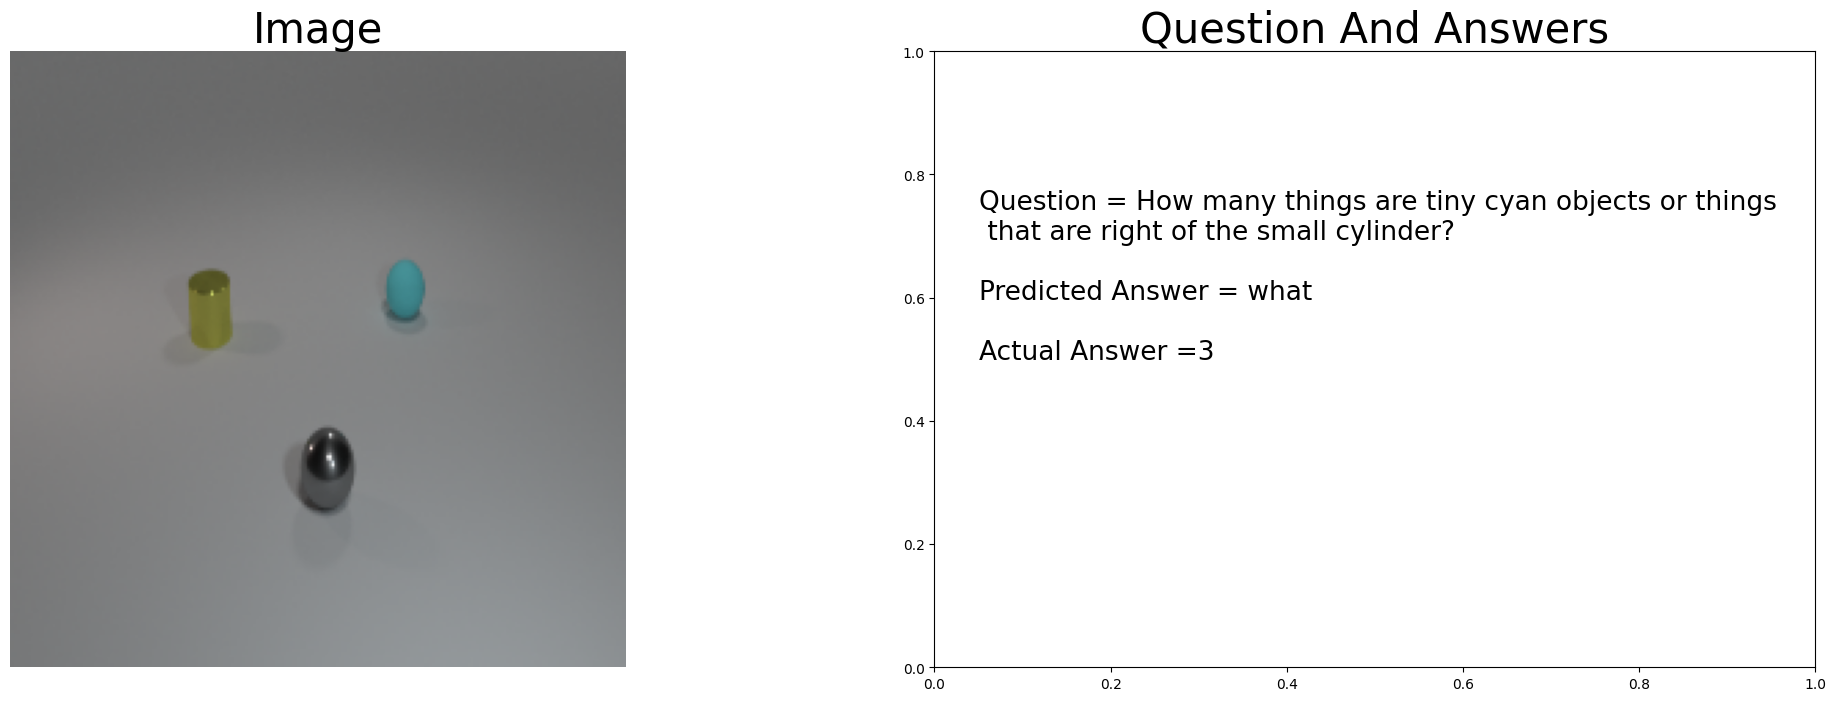

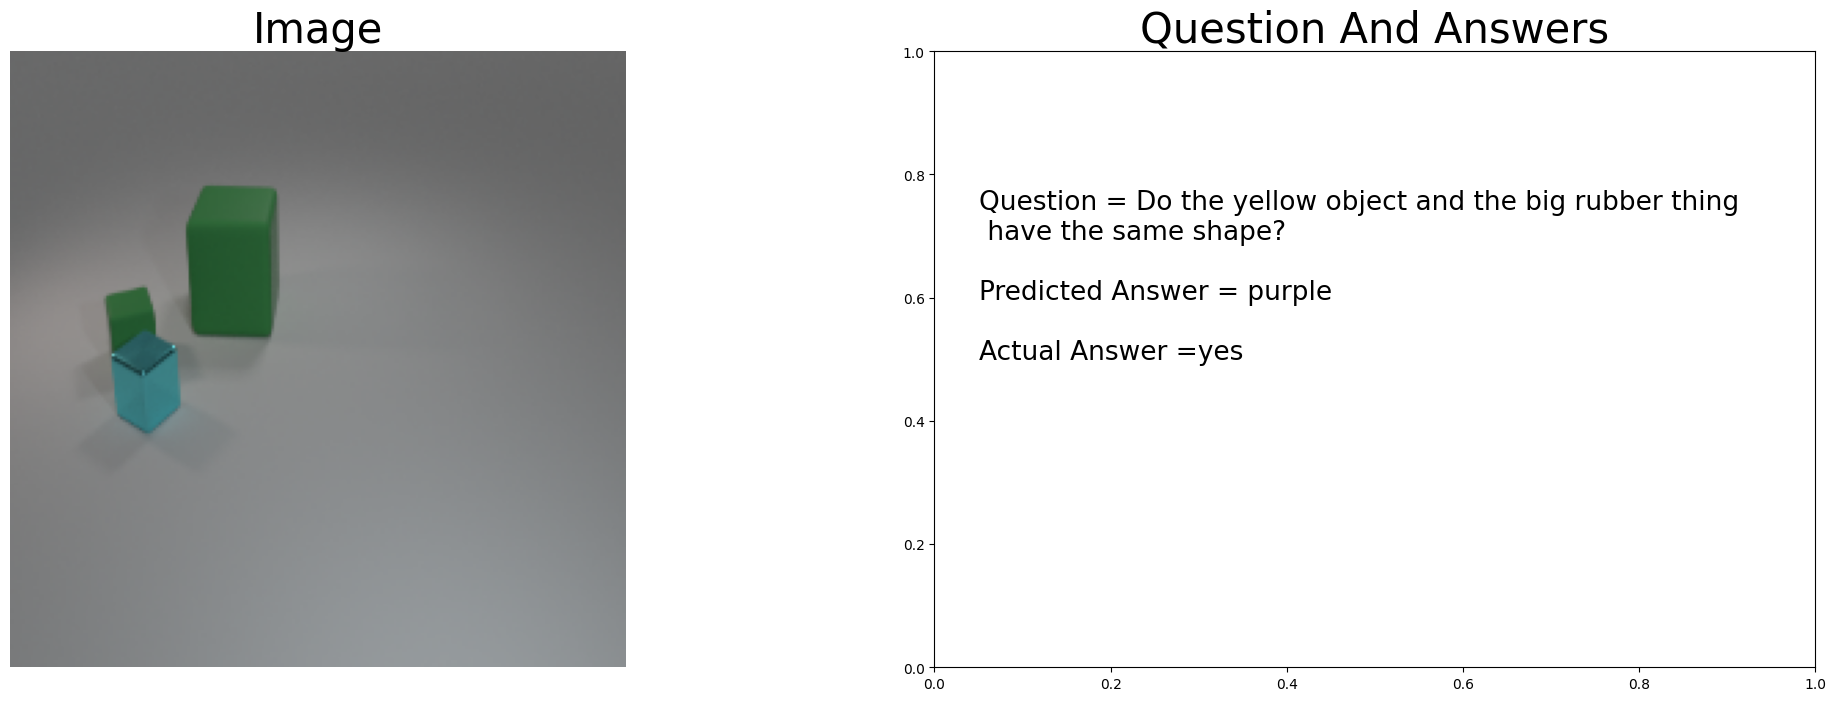

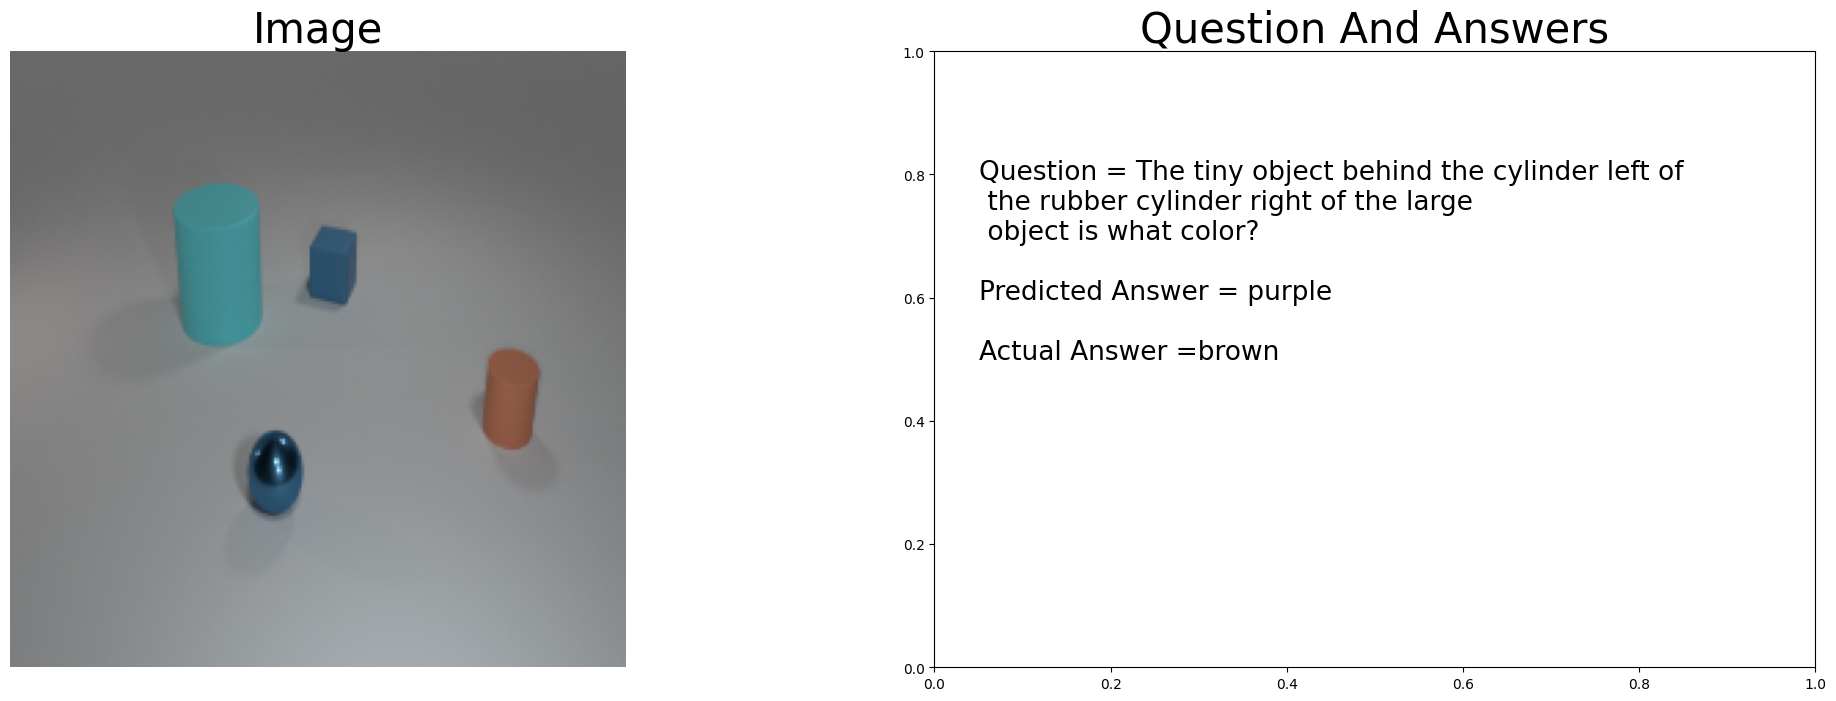

In [40]:
print("Predictions Are as follows = ")

for i in range(5):
    index=random.randrange(5000)
    fig,axis=plt.subplots(1,2,figsize=(25, 8))
    im=cv2.imread(val_dataframe.iloc[index]['Path'])
    print(im.shape)
    im=cv2.resize(im,(224,224))
    q=val_dataframe.iloc[index]['Question']
    q=encoder.encode(q)
    paddings = [[0, 50-tf.shape(q)[0]]]
    q=tf.pad(q, paddings, 'CONSTANT', constant_values=0)
    q=np.array(q)
    print(im.shape)
    print(q.shape)
    im = np.expand_dims(im, axis=0)  # Add an extra dimension for batch size
    q = np.expand_dims(q, axis=0)  # Add an extra dimension for batch size
    inp = [im, q]
    ans = model3.predict(inp)
    question=""
    flag=0
    for i,j in enumerate(val_dataframe.iloc[index]['Question']):
        if (flag==1) and (j==' '):
            question+='\n'
            flag=0
        question+=j
        if (i%40==0)and (i!=0):
            flag=1
    axis[0].imshow(im[0])  # Remove the extra dimension before showing the image
    axis[0].axis('off')
    axis[0].set_title('Image', fontsize=30)
    axis[1].text(0.05,0.5,
             "Question = {}\n\nPredicted Answer = {}\n\nActual Answer ={}".format(question,encoder.decode([np.argmax(ans)]),val_dataframe.iloc[index]['Answer']),
             transform=plt.gca().transAxes,fontsize=19)
    axis[1].axis('on')
    axis[1].set_title('Question And Answers', fontsize=30)

In [41]:
print("Predictions Are as follows = ")
df2 = pd.read_csv("/content/Training Parameters-3_B50.csv")
df2.tail()


Predictions Are as follows = 


epoch      loss        lr  sparse_categorical_accuracy  val_loss  \
5      5  1.033691  0.000670                      0.41965  1.014960   
6      6  1.020200  0.000607                      0.42385  1.010649   
7      7  1.012726  0.000549                      0.42890  1.008849   
8      8  1.008183  0.000497                      0.43170  1.007385   
9      9  1.004728  0.000449                      0.43470  1.008532   

   val_sparse_categorical_accuracy  
5                           0.4372  
6                           0.4400  
7                           0.4424  
8                           0.4398  
9                           0.4402

In [42]:
X = df2['epoch']

font = {'size': 10}
plt.rc('font', **font)

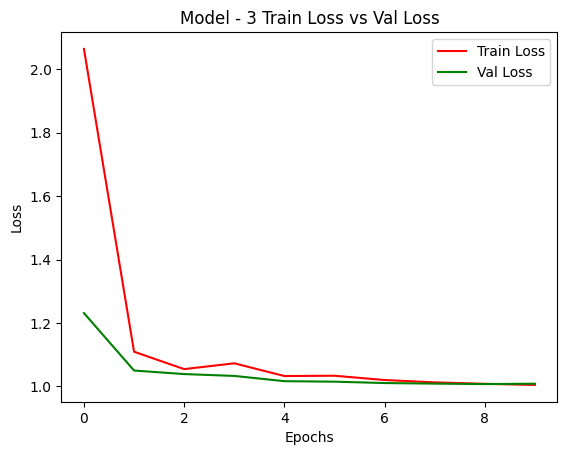

In [43]:
y = df2['loss']
z = df2['val_loss']
  
plt.plot(X, y, color='r', label='Train Loss')
plt.plot(X, z, color='g', label='Val Loss')
  
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model - 3 Train Loss vs Val Loss")
  
plt.legend()
  
plt.show()

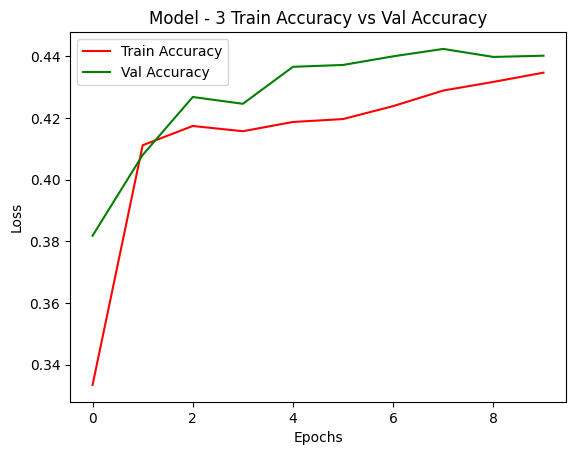

In [44]:
y = df2['sparse_categorical_accuracy']
z = df2['val_sparse_categorical_accuracy']
  
plt.plot(X, y, color='r', label='Train Accuracy')
plt.plot(X, z, color='g', label='Val Accuracy')
  
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model - 3 Train Accuracy vs Val Accuracy")
  
plt.legend()
  
plt.show()

MODEL - 4 VGG-16 + LSTM + Attention

In [45]:
BATCH_SIZE=50
IMG_SIZE=(224,224)


#Function that uses the encoder created to encode the input question and answer string
def encode_fn(text):
    return np.array(encoder.encode(text.numpy()))


#Function to load and decode the image from the file paths in the dataframe and use the encoder function
def preprocess(ip,ans):
    img,ques=ip#ip is a list containing image paths and questions
    img=tf.io.read_file(img)
    img=tf.image.decode_jpeg(img,channels=3)
    # quantos canais de cores tem 
    img=tf.image.resize(img,IMG_SIZE)
    img=tf.math.divide(img, 255)# 
    #The question string is converted to encoded list with fixed size of 50 with padding with 0 value
    ques=tf.py_function(encode_fn,inp=[ques],Tout=tf.int32)
    paddings = [[0, 50-tf.shape(ques)[0]]]
    ques = tf.pad(ques, paddings, 'CONSTANT', constant_values=0)
    ques.set_shape([50])#Explicit shape must be defined in order to create the Input pipeline
    
    #The Answer is also encoded 
    ans=tf.py_function(encode_fn,inp=[ans],Tout=tf.int32)
    ans.set_shape([1])
    
    return (img,ques),ans
    
def create_pipeline(dataframe):
    raw_df=tf.data.Dataset.from_tensor_slices(((dataframe['Path'],dataframe['Question']),dataframe['Answer']))
    df=raw_df.map(preprocess)#Preprocessing function is applied to the dataset
    df=df.batch(BATCH_SIZE)#The dataset is batched
    return df

#The training and validation Dataset objects are created
train_dataset=create_pipeline(train_dataframe)
validation_dataset=create_pipeline(val_dataframe)

In [17]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, Flatten, Multiply, Concatenate, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

image_input = Input(shape=(224, 224, 3), name='image_input')
text_input = Input(shape=(50), name='text_input')


vgg16_encode = vgg16_encoder()
features = vgg16_encode(image_input)
features = Flatten()(features)


embedding_dim = 256
lstm_dim = 256
vocab_size = len(vocab_set)

embedding_layer = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True)
lstm_layer = LSTM(lstm_dim, return_sequences=True)

embedded_text = embedding_layer(text_input)
lstm_output = lstm_layer(embedded_text)

# attention mechanism
attention_weights = Dense(lstm_dim, activation='relu')(features)
attention_weights = Dense(1, activation='softmax')(attention_weights)
attention_weights = Multiply()([lstm_output, attention_weights])
attention_weights = Lambda(lambda x: K.sum(x, axis=1), name='attention_weights')(attention_weights)

# Concatenate features and attention weights
merged_output = Concatenate()([features, attention_weights])
output_layer = Dense(len(vocab_set), activation='softmax', name='output')(merged_output)

model4 = Model(inputs=[image_input, text_input], outputs=output_layer)
model4.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
model4.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_14 (Sequential)     (None, 7, 7, 512)    14714688    ['image_input[0][0]']            
                                                                                                  
 flatten_2 (Flatten)            (None, 25088)        0           ['sequential_14[0][0]']          
                                                                                                  
 text_input (InputLayer)        [(None, 50)]         0           []                         

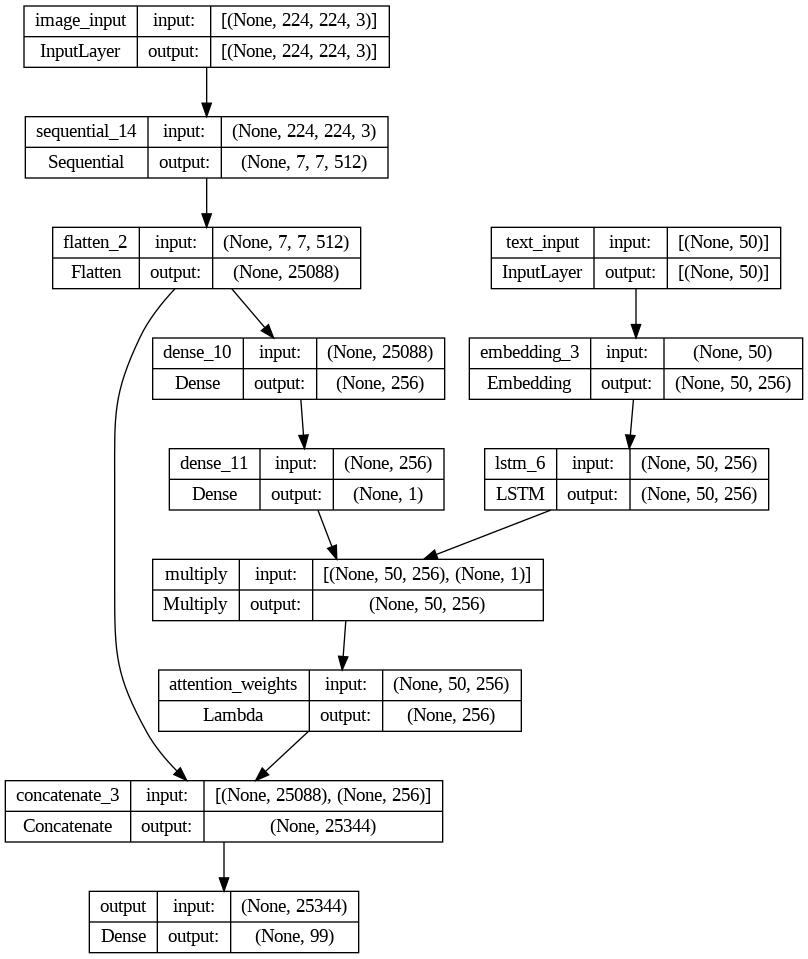

In [18]:
img_file4 = '/content/model-4.png'
tf.keras.utils.plot_model(model4, to_file=img_file4, show_shapes=True)

In [ ]:
tf.random.set_seed(1)

In [ ]:
mc = ModelCheckpoint(mode='max', filepath='/content/Model-4_B50.h5', monitor='val_sparse_categorical_accuracy',save_best_only='True', save_weights_only='True', verbose=1)

In [ ]:
def scheduler(epoch):
  if epoch < 1:
    return 0.001
  else:
    return 0.001 * tf.math.exp(0.1 * (1 - epoch))

LRS = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
csv_callback=tf.keras.callbacks.CSVLogger(
    "Training Parameters-4_B50.csv", separator=',', append=False
)

In [48]:
model4.load_weights('/content/Model-4_B50.h5')

In [2]:
history = model4.fit(train_dataset,
          validation_data= validation_dataset,
          epochs=10,
          callbacks=[mc,LRS,csv_callback] 
         )

MODEL - 4 Evaluation and Results

Predictions Are as follows = 


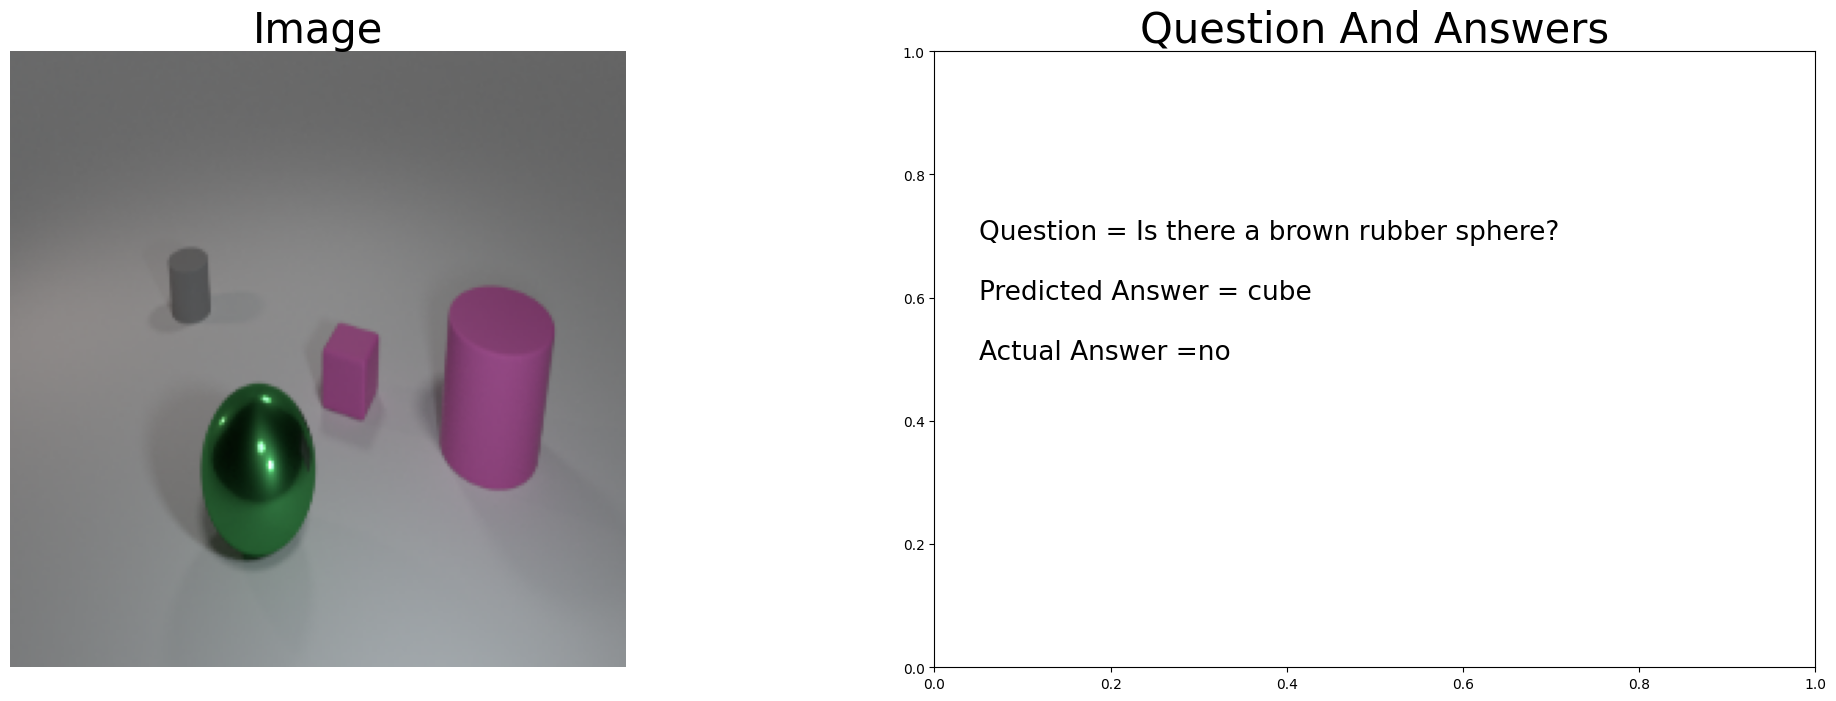

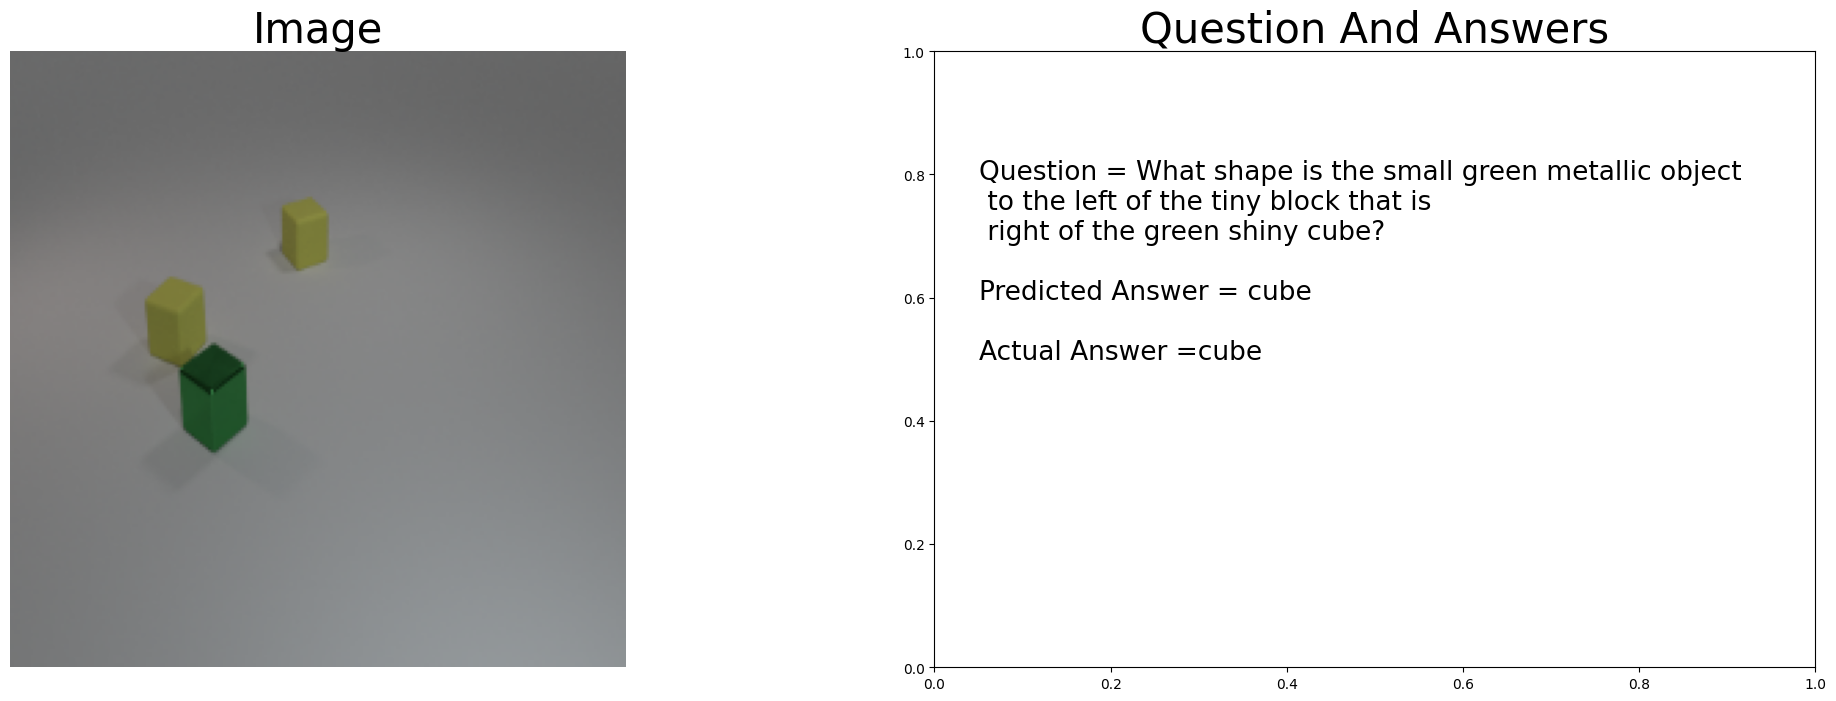

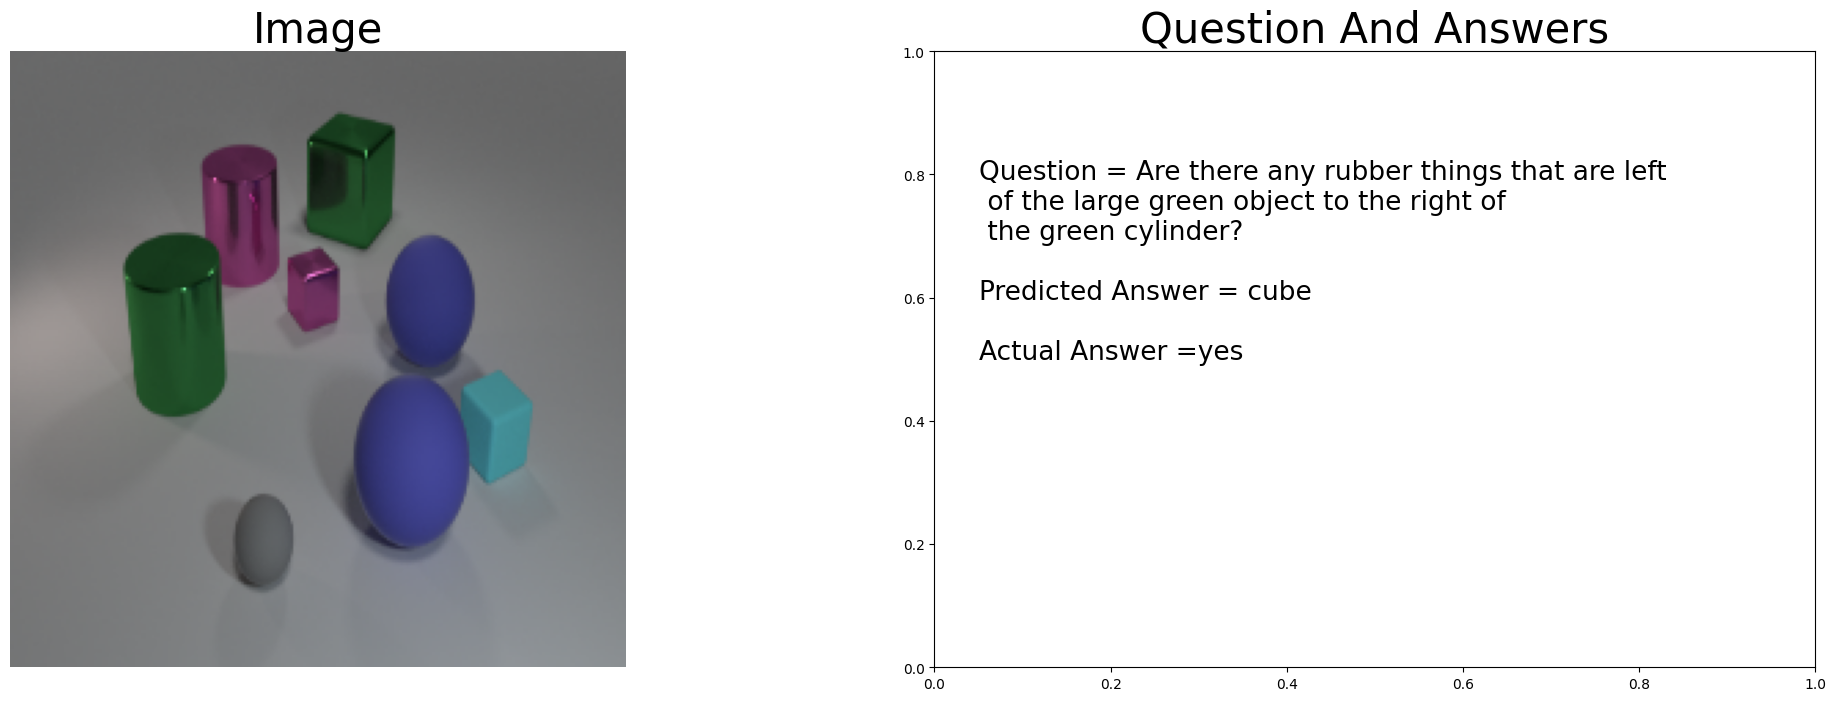

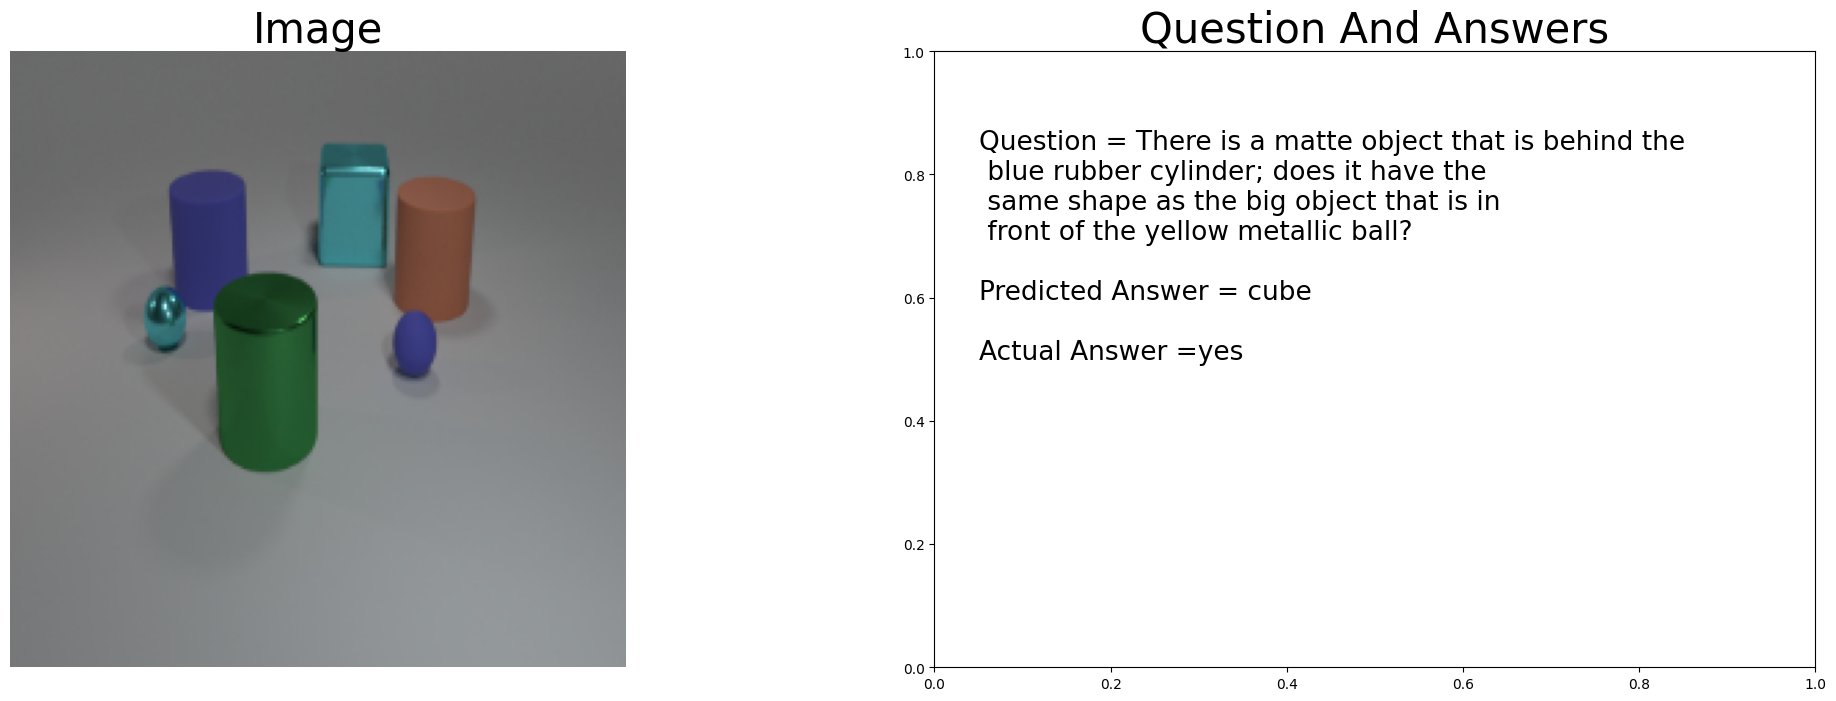

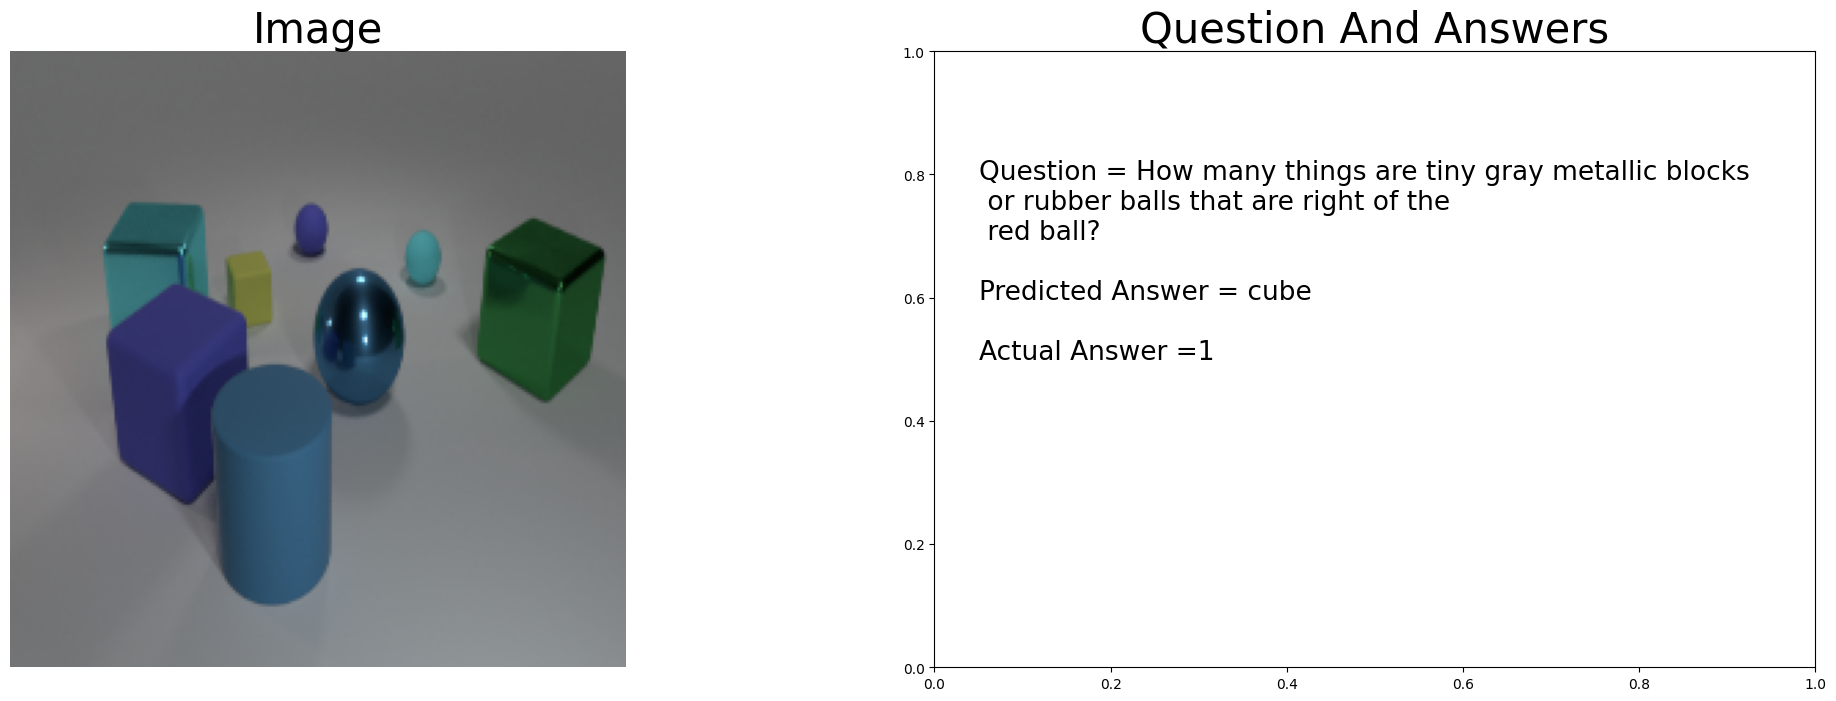

In [52]:
print("Predictions Are as follows = ")

for i in range(5):
    index=random.randrange(5000)
    fig,axis=plt.subplots(1,2,figsize=(25, 8))
    im=cv2.imread(val_dataframe.iloc[index]['Path'])
    im=cv2.resize(im,(224,224))
    q=val_dataframe.iloc[index]['Question']
    q=encoder.encode(q)
    paddings = [[0, 50-tf.shape(q)[0]]]
    q=tf.pad(q, paddings, 'CONSTANT', constant_values=0)
    q=np.array(q)
    #print(im.shape)
    #print(q.shape)
    im = np.expand_dims(im, axis=0)  # Add an extra dimension for batch size
    q = np.expand_dims(q, axis=0)  # Add an extra dimension for batch size
    question=""
    flag=0
    for i,j in enumerate(val_dataframe.iloc[index]['Question']):
        if (flag==1) and (j==' '):
            question+='\n'
            flag=0
        question+=j
        if (i%40==0)and (i!=0):
            flag=1
    axis[0].imshow(im[0])  # Remove the extra dimension before showing the image
    axis[0].axis('off')
    axis[0].set_title('Image', fontsize=30)
    axis[1].text(0.05,0.5,
             "Question = {}\n\nPredicted Answer = {}\n\nActual Answer ={}".format(question,encoder.decode([np.argmax(ans)]),val_dataframe.iloc[index]['Answer']),
             transform=plt.gca().transAxes,fontsize=19)
    axis[1].axis('on')
    axis[1].set_title('Question And Answers', fontsize=30)

In [53]:
print("Predictions Are as follows = ")
df3 = pd.read_csv("/content/Training Parameters-4_B50.csv")
df3.tail()

Predictions Are as follows = 


epoch      loss        lr  sparse_categorical_accuracy  val_loss  \
5      5  1.014424  0.000670                      0.43980  1.019858   
6      6  1.008963  0.000607                      0.44620  1.017278   
7      7  1.000552  0.000549                      0.45585  1.015299   
8      8  0.994377  0.000497                      0.46465  1.014047   
9      9  0.988896  0.000449                      0.46935  1.013860   

   val_sparse_categorical_accuracy  
5                           0.4336  
6                           0.4336  
7                           0.4400  
8                           0.4448  
9                           0.4484

In [54]:
X = df3['epoch']

font = {'size': 10}
plt.rc('font', **font)

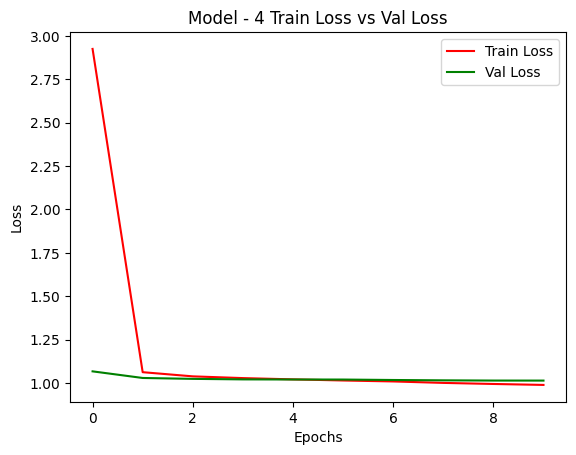

In [55]:
y = df3['loss']
z = df3['val_loss']
  
plt.plot(X, y, color='r', label='Train Loss')
plt.plot(X, z, color='g', label='Val Loss')
  
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model - 4 Train Loss vs Val Loss")
  
plt.legend()
  
plt.show()

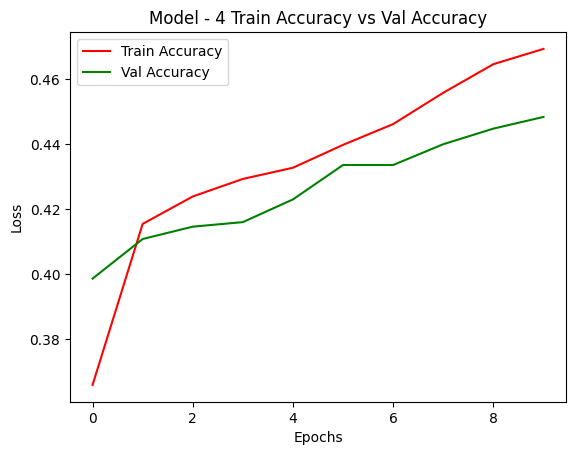

In [56]:
y = df3['sparse_categorical_accuracy']
z = df3['val_sparse_categorical_accuracy']
  
plt.plot(X, y, color='r', label='Train Accuracy')
plt.plot(X, z, color='g', label='Val Accuracy')
  
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model - 4 Train Accuracy vs Val Accuracy")
  
plt.legend()
  
plt.show()

MODEL - 5: MobileNetV2 + BiDirectional LSTM + Dense 

In [57]:
BATCH_SIZE=50
IMG_SIZE=(200,200)


#Function that uses the encoder created to encode the input question and answer string
def encode_fn(text):
    return np.array(encoder.encode(text.numpy()))


#Function to load and decode the image from the file paths in the dataframe and use the encoder function
def preprocess(ip,ans):
    img,ques=ip#ip is a list containing image paths and questions
    img=tf.io.read_file(img)
    img=tf.image.decode_jpeg(img,channels=3)
    # quantos canais de cores tem 
    img=tf.image.resize(img,IMG_SIZE)
    img=tf.math.divide(img, 255)# 
    #The question string is converted to encoded list with fixed size of 50 with padding with 0 value
    ques=tf.py_function(encode_fn,inp=[ques],Tout=tf.int32)
    paddings = [[0, 50-tf.shape(ques)[0]]]
    ques = tf.pad(ques, paddings, 'CONSTANT', constant_values=0)
    ques.set_shape([50])#Explicit shape must be defined in order to create the Input pipeline
    
    #The Answer is also encoded 
    ans=tf.py_function(encode_fn,inp=[ans],Tout=tf.int32)
    ans.set_shape([1])
    
    return (img,ques),ans
    
def create_pipeline(dataframe):
    raw_df=tf.data.Dataset.from_tensor_slices(((dataframe['Path'],dataframe['Question']),dataframe['Answer']))
    df=raw_df.map(preprocess)#Preprocessing function is applied to the dataset
    df=df.batch(BATCH_SIZE)#The dataset is batched
    return df

#The training and validation Dataset objects are created
train_dataset=create_pipeline(train_dataframe)
validation_dataset=create_pipeline(val_dataframe)

In [19]:
#Creating the CNN model for image processing
CNN_Input=tf.keras.layers.Input(shape=(200,200,3),name='image_input')

mobilenetv2=tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(200,200,3), alpha=1.0, include_top=False,
                                                          weights='imagenet', input_tensor=CNN_Input)

CNN_model=tf.keras.models.Sequential()
CNN_model.add(CNN_Input)
CNN_model.add(mobilenetv2)

CNN_model.add(tf.keras.layers.GlobalAveragePooling2D())

#Creating the RNN model for text processing
RNN_model=tf.keras.models.Sequential()

RNN_Input=tf.keras.layers.Input(shape=(50),name='text_input')
RNN_model.add(RNN_Input)
RNN_model.add(tf.keras.layers.Embedding (len(vocab_set),256))
RNN_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256,stateful=False,return_sequences=True,recurrent_initializer='glorot_uniform')))
RNN_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256,stateful=False,return_sequences=True,recurrent_initializer='glorot_uniform')))
RNN_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512,stateful=False,return_sequences=False,recurrent_initializer='glorot_uniform')))


concat=tf.keras.layers.concatenate([CNN_model.output,RNN_model.output])
x = tf.keras.layers.Dense(512, activation='relu')(concat)
x = tf.keras.layers.Dense(256, activation='relu')(x)
dense_out=tf.keras.layers.Dense(len(vocab_set),activation='softmax',name='output')(x)

model5 = tf.keras.Model(inputs=[CNN_Input,RNN_Input], outputs=dense_out)
model5.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
model5.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 50)]         0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 50, 256)      25344       ['text_input[0][0]']             
                                                                                                  
 image_input (InputLayer)       [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 bidirectional_6 (Bidirectional  (None, 50, 512)     1050624     ['embedding_4[0][0]']      

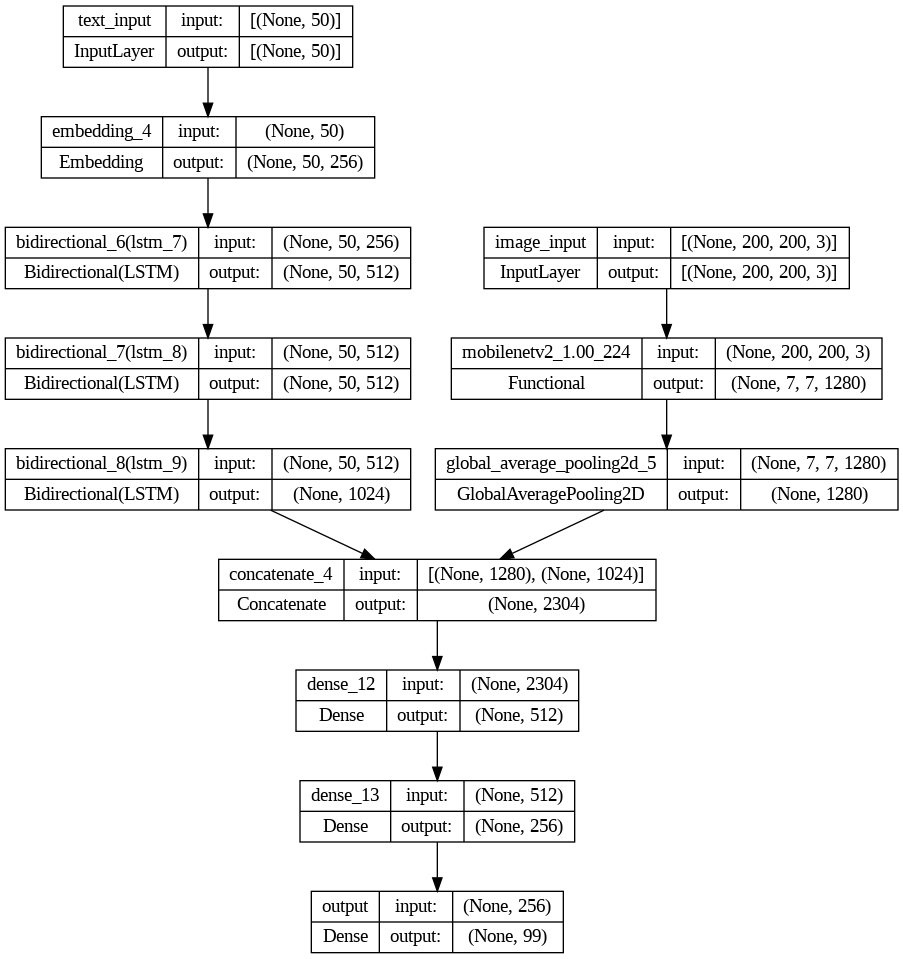

In [20]:
img_file5 = '/content/model-5.png'
tf.keras.utils.plot_model(model5, to_file=img_file5, show_shapes=True)

In [59]:
tf.random.set_seed(1)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, TensorBoard

In [ ]:
mc = ModelCheckpoint(mode='max', filepath='/content/Model-5_B50.h5', monitor='val_sparse_categorical_accuracy',save_best_only='True', save_weights_only='True', verbose=1)

In [ ]:
csv_callback=tf.keras.callbacks.CSVLogger(
    "Training Parameters-5_B50.csv", separator=',', append=False
)

In [ ]:
def scheduler(epoch):
  if epoch < 1:
    return 0.001
  else:
    return 0.001 * tf.math.exp(0.1 * (1 - epoch))

LRS = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [60]:
model5.load_weights('/content/Model-5_B50.h5')

In [ ]:
history = model5.fit(train_dataset,
          validation_data= validation_dataset,
          epochs=10,
          callbacks=[mc,LRS,csv_callback] 
         )

Epoch 1/10
400/400 [==============================] - ETA: 0s - loss: 1.8182 - sparse_categorical_accuracy: 0.3031
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.14300, saving model to /content/Model-1a.h5
400/400 [==============================] - 277s 551ms/step - loss: 1.8182 - sparse_categorical_accuracy: 0.3031 - val_loss: 3.0006 - val_sparse_categorical_accuracy: 0.1430 - lr: 0.0010
Epoch 2/10
400/400 [==============================] - ETA: 0s - loss: 1.4395 - sparse_categorical_accuracy: 0.3623
Epoch 2: val_sparse_categorical_accuracy improved from 0.14300 to 0.37280, saving model to /content/Model-1a.h5
400/400 [==============================] - 204s 510ms/step - loss: 1.4395 - sparse_categorical_accuracy: 0.3623 - val_loss: 1.5067 - val_sparse_categorical_accuracy: 0.3728 - lr: 0.0010
Epoch 3/10
400/400 [==============================] - ETA: 0s - loss: 1.1715 - sparse_categorical_accuracy: 0.4041
Epoch 3: val_sparse_categorical_accuracy improved from 0.37280

MODEL - 5 Evaluation and Results

Predictions Are as follows = 
(320, 480, 3)
(200, 200, 3)
(50,)
1/1 [==============================] - 0s 38ms/step
(320, 480, 3)
(200, 200, 3)
(50,)
1/1 [==============================] - 0s 35ms/step
(320, 480, 3)
(200, 200, 3)
(50,)
1/1 [==============================] - 0s 32ms/step
(320, 480, 3)
(200, 200, 3)
(50,)
1/1 [==============================] - 0s 35ms/step
(320, 480, 3)
(200, 200, 3)
(50,)
1/1 [==============================] - 0s 34ms/step


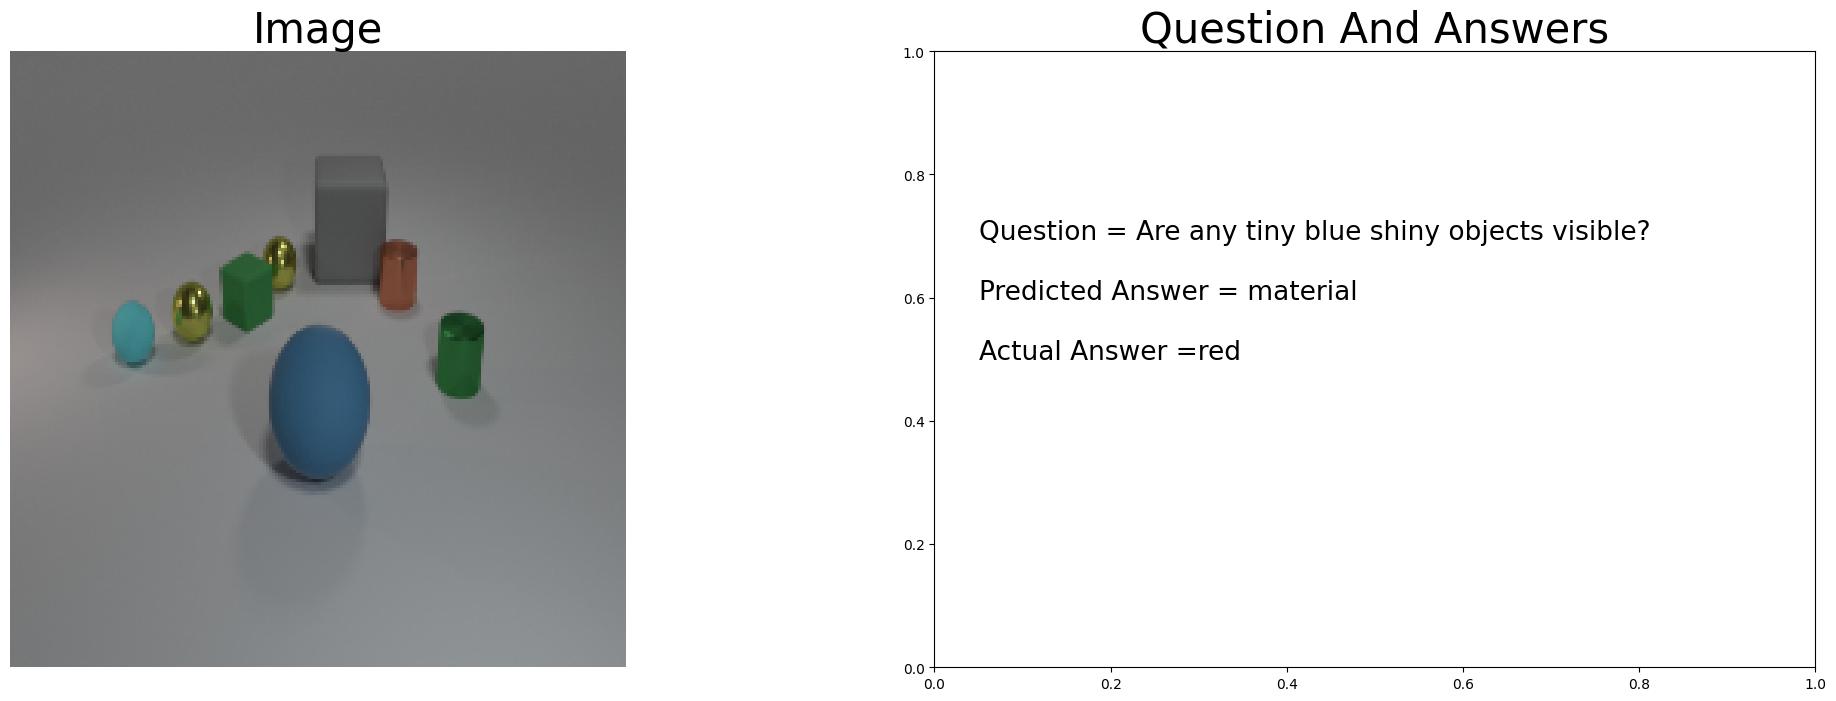

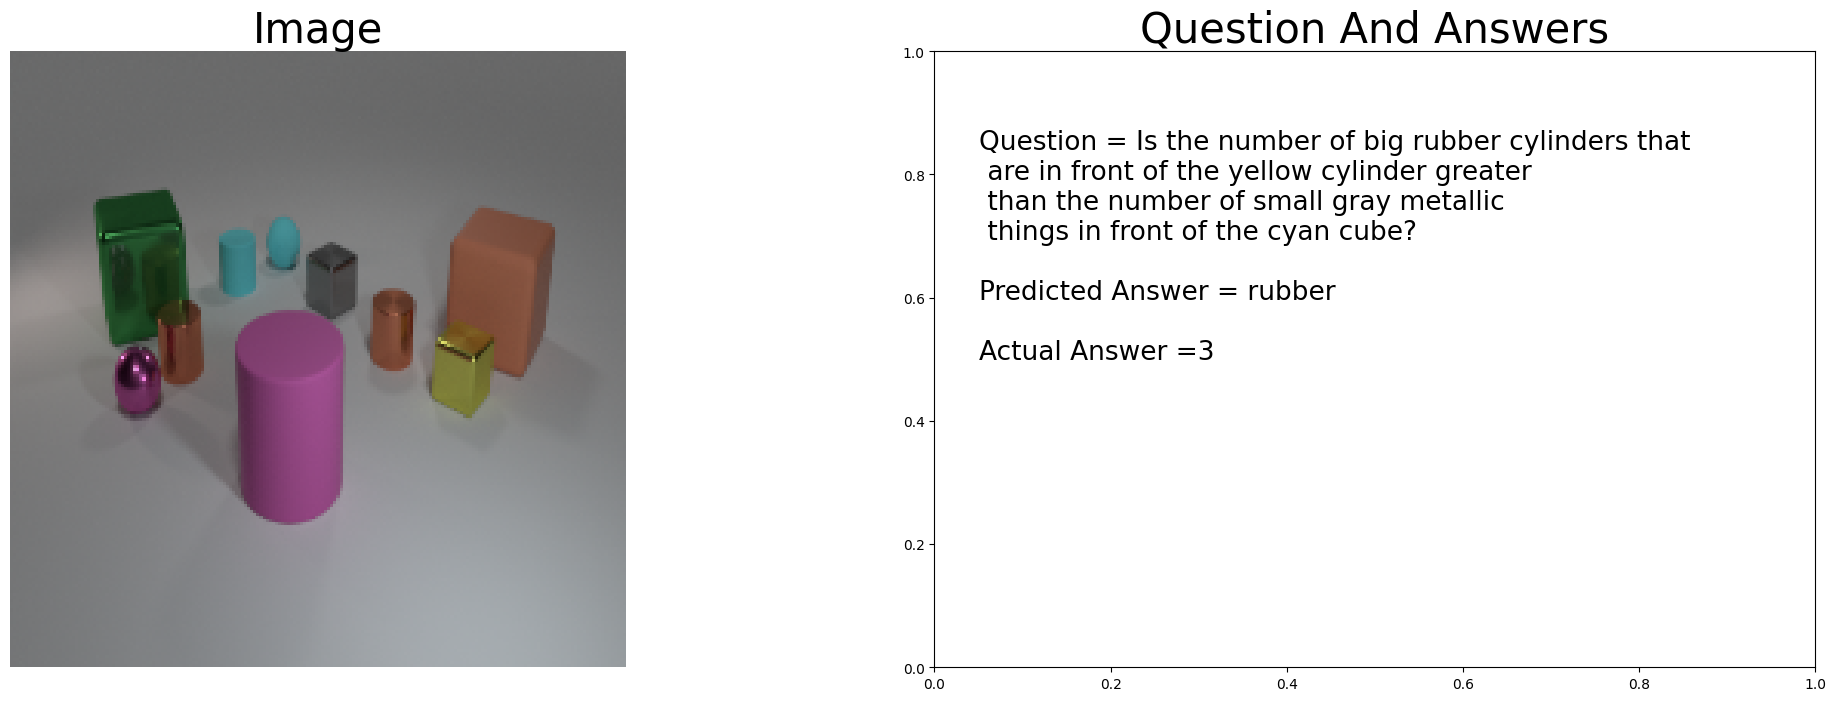

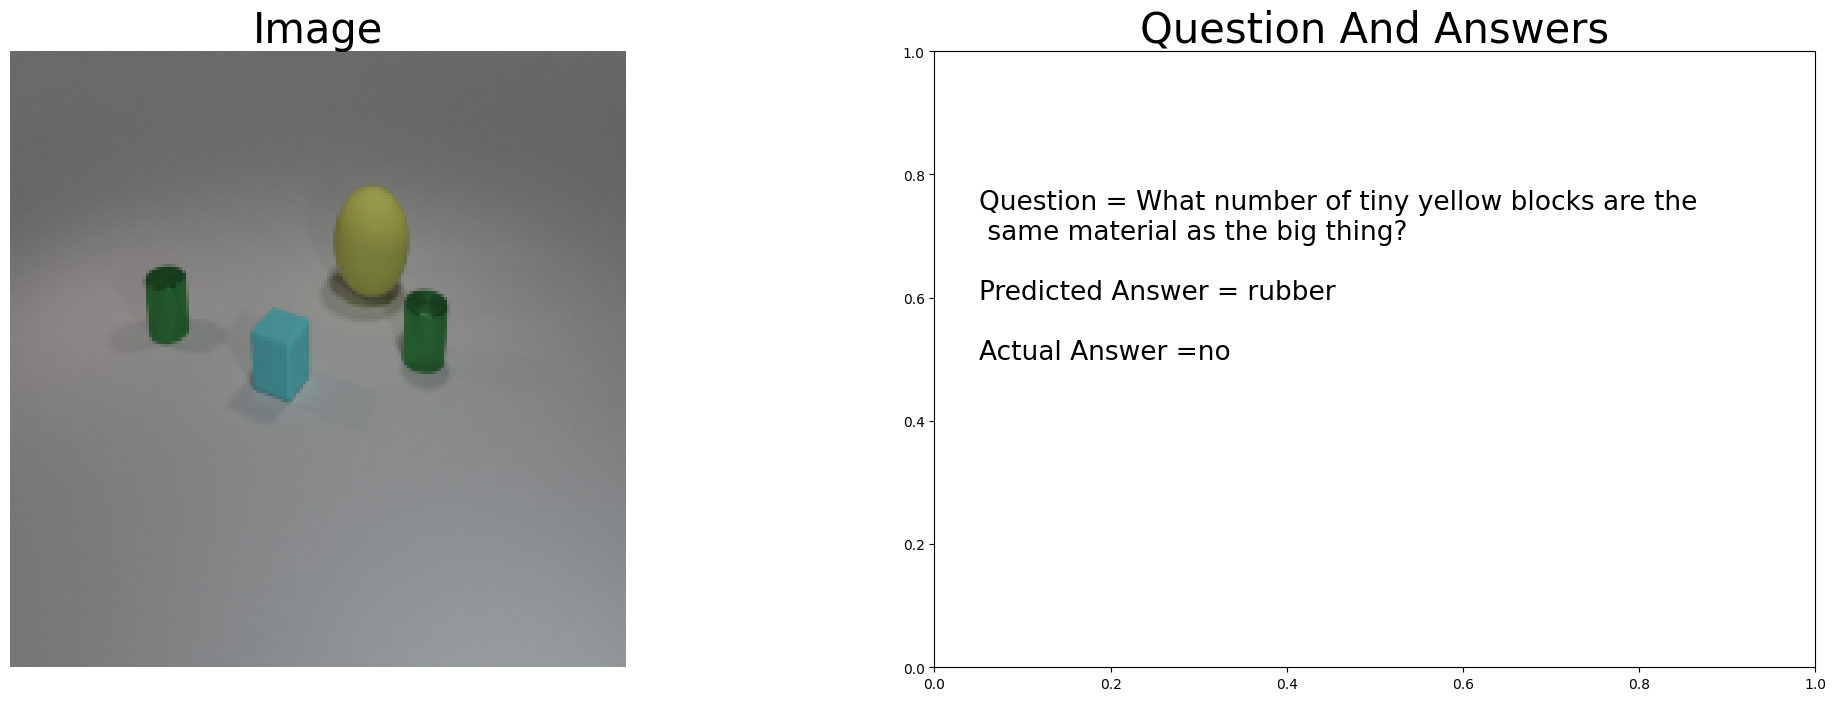

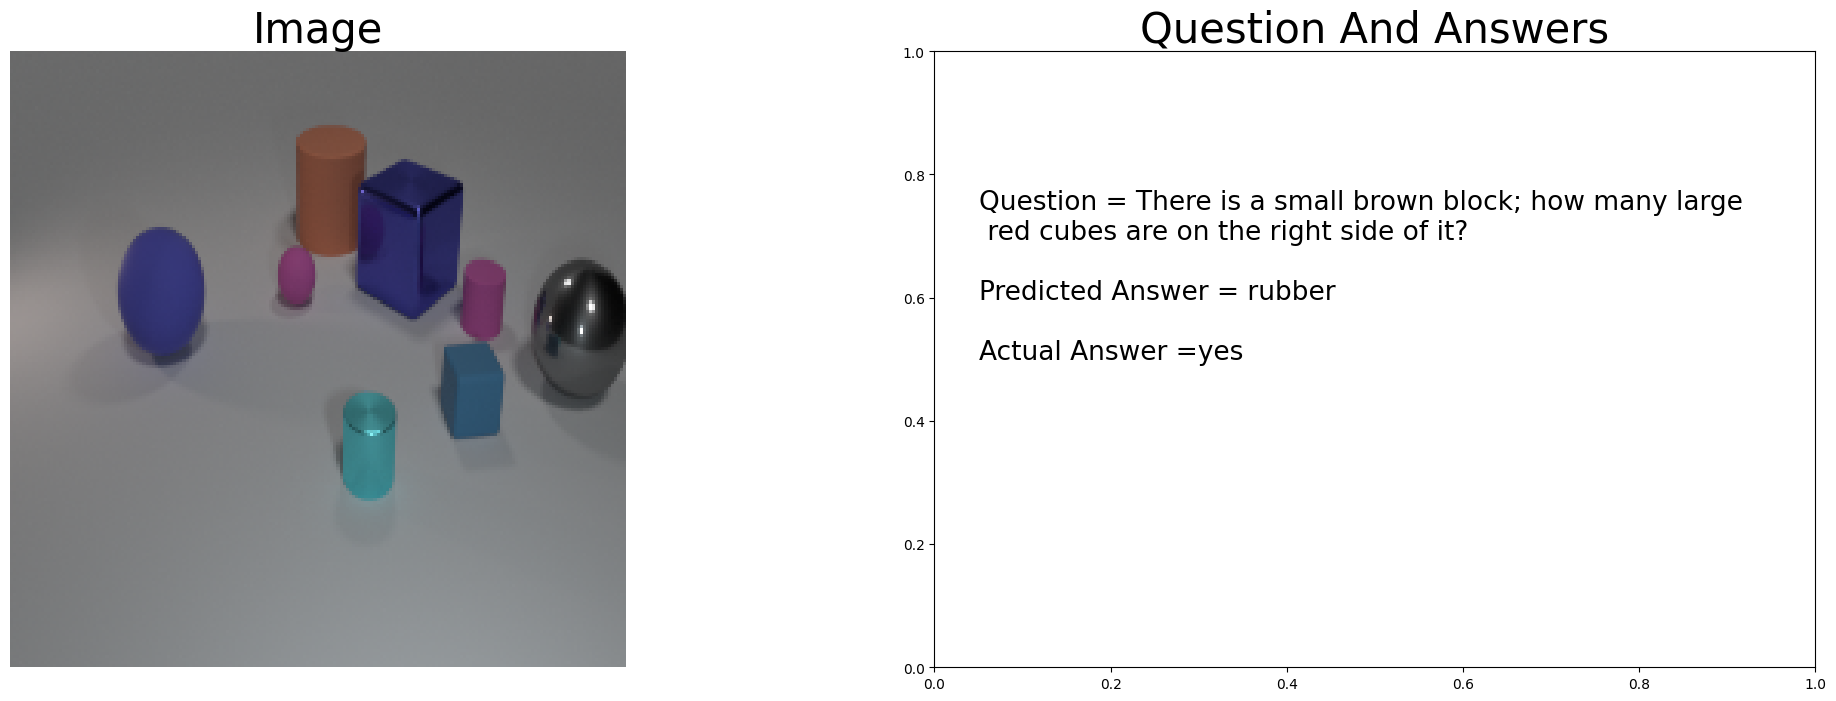

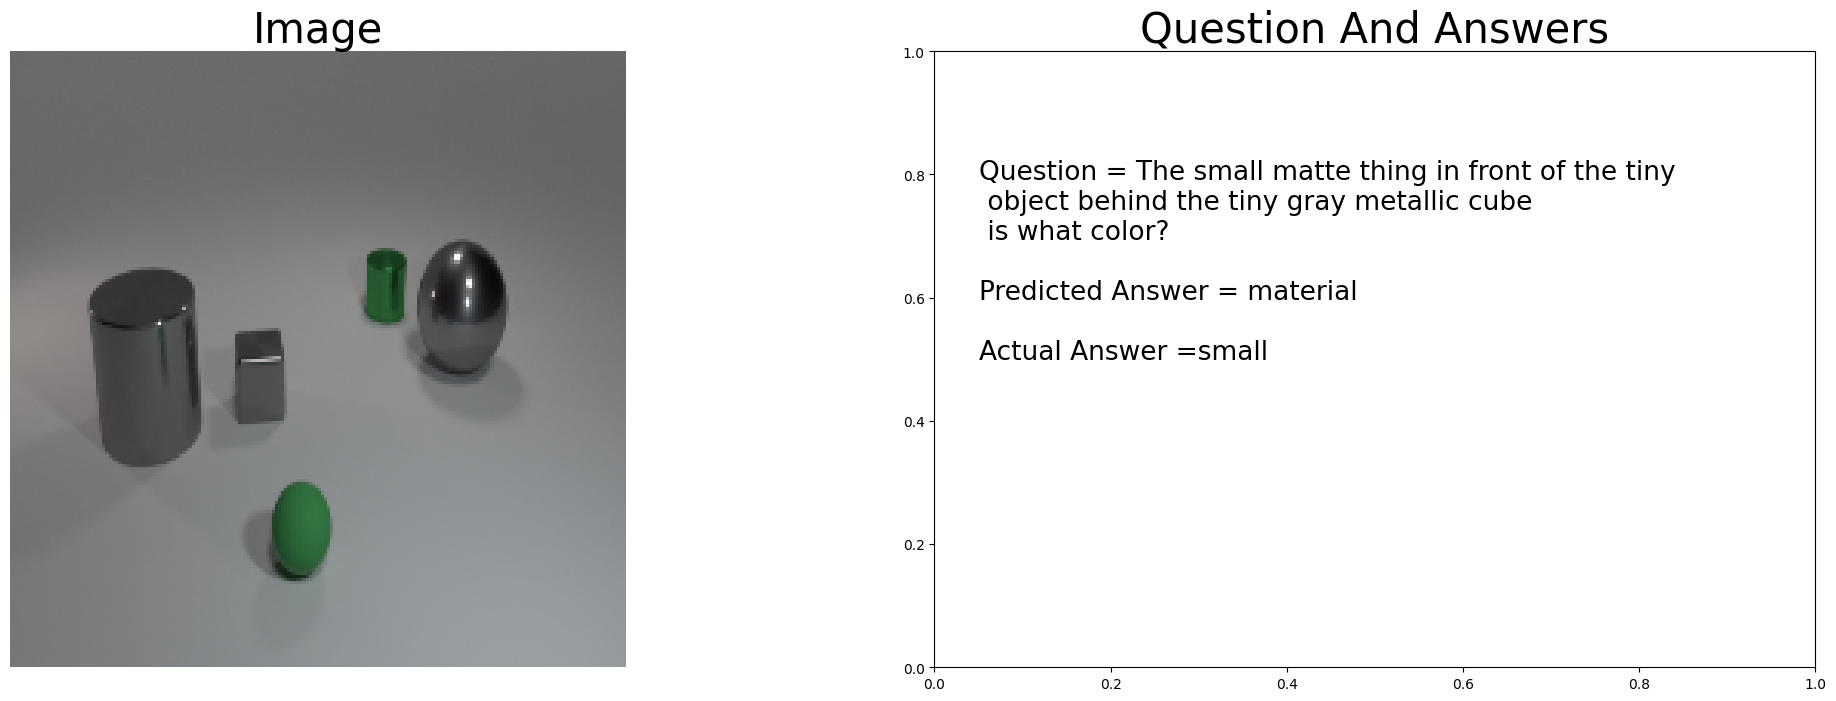

In [62]:
print("Predictions Are as follows = ")

for i in range(5):
    index=random.randrange(5000)
    fig,axis=plt.subplots(1,2,figsize=(25, 8))
    im=cv2.imread(train_dataframe.iloc[index]['Path'])
    print(im.shape)
    im=cv2.resize(im,(200,200))
    q=train_dataframe.iloc[index]['Question']
    q=encoder.encode(q)
    paddings = [[0, 50-tf.shape(q)[0]]]
    q=tf.pad(q, paddings, 'CONSTANT', constant_values=0)
    q=np.array(q)
    print(im.shape)
    print(q.shape)
    im = np.expand_dims(im, axis=0)  # Add an extra dimension for batch size
    q = np.expand_dims(q, axis=0)  # Add an extra dimension for batch size
    inp = [im, q]
    ans = model5.predict(inp)
    question=""
    flag=0
    for i,j in enumerate(train_dataframe.iloc[index]['Question']):
        if (flag==1) and (j==' '):
            question+='\n'
            flag=0
        question+=j
        if (i%40==0)and (i!=0):
            flag=1
    axis[0].imshow(im[0])  # Remove the extra dimension before showing the image
    axis[0].axis('off')
    axis[0].set_title('Image', fontsize=30)
    axis[1].text(0.05,0.5,
             "Question = {}\n\nPredicted Answer = {}\n\nActual Answer ={}".format(question,encoder.decode([np.argmax(ans)]),val_dataframe.iloc[index]['Answer']),
             transform=plt.gca().transAxes,fontsize=19)
    axis[1].axis('on')
    axis[1].set_title('Question And Answers', fontsize=30)

In [63]:
print("Predictions Are as follows = ")
df4 = pd.read_csv("/content/Training Parameters-5_B50.csv")
df4.tail()

Predictions Are as follows = 


epoch      loss        lr  sparse_categorical_accuracy  val_loss  \
5      5  1.013051  0.000670                      0.43230  1.053839   
6      6  1.007722  0.000607                      0.43560  1.051152   
7      7  1.058081  0.000549                      0.43190  1.078430   
8      8  0.997435  0.000497                      0.44095  1.149266   
9      9  0.994975  0.000449                      0.44870  1.599518   

   val_sparse_categorical_accuracy  
5                           0.4356  
6                           0.4456  
7                           0.4390  
8                           0.4434  
9                           0.4224

In [64]:
X = df4['epoch']

font = {'size': 10}
plt.rc('font', **font)

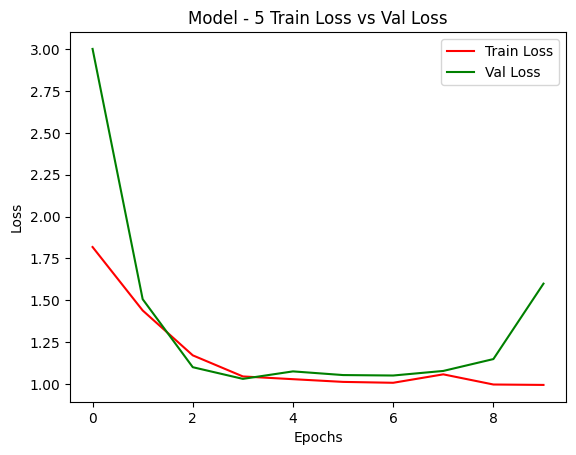

In [65]:
y = df4['loss']
z = df4['val_loss']
  
plt.plot(X, y, color='r', label='Train Loss')
plt.plot(X, z, color='g', label='Val Loss')
  
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model - 5 Train Loss vs Val Loss")
  
plt.legend()
  
plt.show()

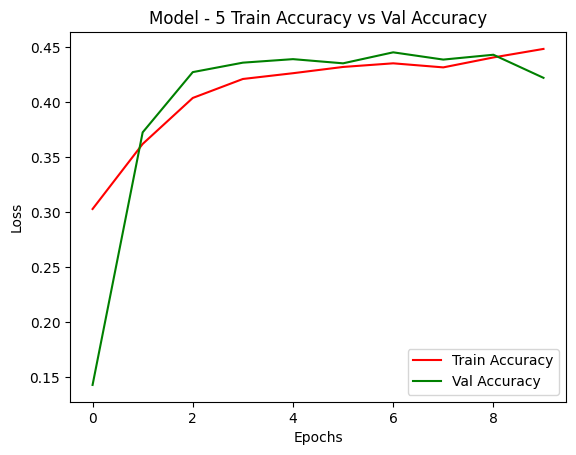

In [66]:
y = df4['sparse_categorical_accuracy']
z = df4['val_sparse_categorical_accuracy']
  
plt.plot(X, y, color='r', label='Train Accuracy')
plt.plot(X, z, color='g', label='Val Accuracy')
  
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model - 5 Train Accuracy vs Val Accuracy")
  
plt.legend()
  
plt.show()